<table>
    <tr><td><h1>Proyecto Final de Maestría</h1></td><td> <img width="284" height="57" src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" alt="UNIR" /> </td></tr>
</table>

---


# Aprendizaje automático para la predicción del consumo eléctrico de Guatemala según condiciones meteorológicas




<table>
    <tr>
        <td>Estudio presentado por: </td>
        <td>Andrés Sebastián Mateo de Acosta Zea</td>
    </tr>
    <tr>
        <td>Tipo de trabajo: </td>
        <td>Técnicas estadísticas e inteligencia artificial y su aplicación para el análisis masivo de datos.</td>    
    </tr>
    <tr>
        <td>Director: </td>
        <td>Luis Heriberto García Islas</td>
    </tr>
    <tr>
        <td>Fecha: </td>
        <td>31 de julio de 2023</td>    
    </tr>
</table>

---

## Preparación del entrono de trabajo
Se declaran los módulos necesarios para completar el ejercicio.

In [142]:
# Importar librerias necesarias para la ejecucion de la actividad
import pandas as pd                                       # Exploracion de datos usando data frames
import numpy as np                                        # Analisis estadistico y numerico
import xarray as xr
import matplotlib.pyplot as plt                           # Visualizacion de datos
import seaborn as sns                                     # Libreria de visualizacion
import geopandas as gpd
import osmnx as ox
import time

from sklearn import preprocessing as prep                 # Convierte variables categoricas a un equivalente numerico
from sklearn.model_selection import train_test_split      # Funcion para distribuir instancias en grupos de prueba y entrenamientofrom sklearn.metrics import accuracy_score 
from sklearn import metrics as mt                         # Modulo para calculo de precision

import tensorflow as tf
import keras
from keras import layers                                  # Creacion de modelos basados en redes neuronales
import keras_tuner as kt                                  # Optimizados de hiperparametros

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

### Funciones de extracción y formato

In [ ]:
# Los parametros requeridos son: DF de la variable climatologica revisada (dtmp), cantidad de columnas del DF a considerar (include), periodo minimo de analisis (cond) y lista con nombres de variables del clima (var)
def MeltDF(dtmp, include, cond, value):
    temp = dtmp.iloc[:,:include]
    temp1 = temp.melt(id_vars = ['YEAR'], var_name = 'MONTH', value_name = value.upper())
    temp1['YEAR'] = temp1['YEAR'].astype('int')
    tempf = temp1[temp1['YEAR'] >= cond]
    tempf['MONTH'] = pd.to_datetime(tempf['MONTH'], format = '%b').dt.month
    return tempf.sort_values(by=['YEAR', 'MONTH'])

In [3]:
# Los parametros necesarios son la direccion web para recuperar los archivos .per (target_url), asi como las listas de DF climaticos (weather_v) y nombres de variables (var)
def ExtractPer(target_url, weather_v, var):
    data = pd.read_table(target_url, header = None)
    data1 = data.iloc[3:,]
    data1[0] = data1[0].str.replace(r'(.)\1{2,}', ',', regex = True)
    data1 = data1.iloc[:, 0].str.split(',', expand = True)
    for i in data1.columns:
        data1[i] = data1[i].str.strip()
    data1.columns = data1.iloc[0]
    data1 = data1.drop(data1.index[0])
    data2 = MeltDF(data1, 13, 2019, var)
    weather_v.append(data2)

In [4]:
# Funcion para crear clase_gasto
def crear_clase(dfd):
  classes = []
  for y in dfd['gasto']:
      if y >= 0 and y <= 5:
          classes.append(0)
      elif  y >= 6 and y <= 10:
          classes.append(1)
      else:
          classes.append(2)
  # Añadirlo al dataset dfFinal
  dfd['clase_gasto'] = classes

# Funcion para reemplazar valores negativos por cero
def negativo_cero(dfd):
  dfd.loc[dfd.cases < 0, 'cases'] = 0
  dfd.loc[dfd.deaths < 0, 'deaths'] = 0
  if 'Cumulative_two_weeks' in dfd.columns:
    dfd.loc[dfd.Cumulative_two_weeks < 0, 'Cumulative_two_weeks'] = 0

## Selección de problema
La mayor parte de países de América realizó graves interrupciones en los servicios esenciales de atención primaria de salud debido a una escasez en la situación económica global. Los gobiernos han decidido desviar recursos humanos y financieros para ampliar la capacidad de las unidades de cuidados intensivos (UCI), servicios hospitalarios y aplicar vacunas contra COVID-19 a corto plazo. Sin embargo, se están abandonando sectores fundamentales como programas de inmunización rutinaria, apoyo para el tratamiento de enfermedades crónicas y servicios de salud mental y reproductiva. Esto podría reducir considerablemente la calidad de vida de los habitantes a mediano y corto plazo si no se toman medidas adecuadas para redirigir los fondos de inversión a salud <a href='https://www.paho.org/es/noticias/10-11-2021-se-necesita-inversion-urgente-atencion-primaria-salud-para-garantizar'>(OPS, 2021)</a>. 
Además, se determinó que al aumentar las intervenciones de atención primaria de salud en países de ingresos bajos y medianos, se podría aumentar su esperanza de vida en 3.7 años <a href='https://www.who.int/es/news-room/fact-sheets/detail/primary-health-care'>(OMS, 2021)</a>.
De esta manera, se considera importante determinar que existe una relación entre el porcentaje de PIB dirigido hacia el sector de salud y la cantidad de decesos causados por COVID-19 en un país.

### Planteamiento de hipótesis
<ul>
<li><b>Hipótesis nula (H0):</b> No existe una relación entre la cantidad por contagio de COVID-19 y el porcentaje del PIB para inversión en salud por país.</li>
<li><b>Hipótesis alternativa (H1):</b> Existe una relación entre la cantidad por contagio de COVID-19 y el porcentaje del PIB para inversión en salud por país.</li>
</ul>

### Variables
<ul>
<li><b>Entrada o independientes:</b> Casos de contagio por COVID-19, cantidad de decesos por COVID-19, tasa de defunciones por COVID-19 (relativa a la población)</li>
<li><b>Salida o dependiente:</b> Clasificación del nivel de inversión en salud como parte del PIB nacional.</li>
</ul>

## Exploración de la fuente primaria

### Importar dataset

#### Generar códigos regionales para el estudio

In [5]:
# Generates statal codes to obtain a regional geodataframe from OpenStreetMaps
names = []
for i in range(0, 22):
  names.append('GT-')
  if (i < 9):
    names[i] += '0' + str(i + 1)
  else:
    names[i] += str(i + 1)

In [6]:
# Retrieve geodataframe from regional codes for OSM import
places = ox.geocode_to_gdf(names)

# Formatting geodf places
# Add two columns with separate administrative names
places[['name', 'country_name']] = places.display_name.str.split(', ', expand=True)
# Get the name capital state
places['name'][0] = places['name'][0].split(" ")[0]
# Set all the state names to uppercase
places['name'] = places['name'].str.upper()
# Remove accents for each regional name
places['name'] = places['name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
places

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance,name,country_name
0,"POLYGON ((-90.75957 14.73598, -90.75933 14.731...",14.915136,14.240037,-90.210978,-90.759568,298051326,relation,214704,14.642470,-90.513135,"Guatemala Department, Guatemala",boundary,administrative,0.452553,GUATEMALA,Guatemala
1,"POLYGON ((-90.40518 14.86291, -90.40515 14.862...",15.152790,14.667343,-89.792982,-90.405179,299455903,relation,214697,14.910044,-90.068273,"El Progreso, Guatemala",boundary,administrative,0.419111,EL PROGRESO,Guatemala
2,"POLYGON ((-90.88092 14.47462, -90.85277 14.449...",14.721912,14.383430,-90.609194,-90.880917,298054696,relation,214703,14.553176,-90.754702,"Sacatepéquez, Guatemala",boundary,administrative,0.423610,SACATEPEQUEZ,Guatemala
3,"POLYGON ((-91.12867 14.46008, -91.12526 14.459...",14.938498,14.369445,-90.619370,-91.128666,298050588,relation,214715,14.653975,-90.927274,"Chimaltenango, Guatemala",boundary,administrative,0.427802,CHIMALTENANGO,Guatemala
4,"POLYGON ((-91.53566 14.04448, -91.53450 14.043...",14.474620,13.909643,-90.581370,-91.535655,298051954,relation,214714,14.192074,-91.027995,"Escuintla, Guatemala",boundary,administrative,0.433383,ESCUINTLA,Guatemala
5,"POLYGON ((-90.67398 14.01905, -90.66031 13.932...",14.505147,13.795392,-90.046921,-90.673979,299327260,relation,9565597,14.150152,-90.350882,"Santa Rosa, Guatemala",boundary,administrative,0.421994,SANTA ROSA,Guatemala
6,"POLYGON ((-91.50665 14.60152, -91.49528 14.597...",14.893421,14.514365,-91.068589,-91.506646,298051293,relation,214713,14.703941,-91.282818,"Sololá, Guatemala",boundary,administrative,0.426477,SOLOLA,Guatemala
7,"POLYGON ((-91.55578 14.93857, -91.55524 14.938...",15.253473,14.823481,-91.175316,-91.555783,298079309,relation,214709,15.042344,-91.406146,"Totonicapán, Guatemala",boundary,administrative,0.408908,TOTONICAPAN,Guatemala
8,"POLYGON ((-92.13850 14.62100, -92.13844 14.620...",15.225884,14.492971,-91.403299,-92.138498,298109544,relation,214710,14.859464,-91.593159,"Quetzaltenango, Guatemala",boundary,administrative,0.445413,QUETZALTENANGO,Guatemala
9,"POLYGON ((-91.67029 14.12416, -91.66924 14.123...",14.705294,14.044479,-91.093311,-91.670288,298058364,relation,214696,14.374900,-91.364955,"Suchitepéquez, Guatemala",boundary,administrative,0.427623,SUCHITEPEQUEZ,Guatemala


#### Extraer los datasets desde el portal POWER

In [7]:
# Sample link: site_name = "https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX&community=RE&longitude=-89.9400&latitude=14.6500&start=20220101&end=20221231&format=CSV"
site_start_name = "https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX&community=RE&longitude="
site_lat_name = "&latitude="
site_end_name = "&start=20220101&end=20221231&format=CSV"

# Create a list of meteorological datasets
dfs = list()

# Extract latitude and longitude from geodataframe to combine the dataframes
for i in range(0, 22):
    lat = round(places['lat'][i], 4)
    lon = round(places['lon'][i], 4)
    region_name = places['name'][i]
    site_name = "{}{}{}{}{}".format(site_start_name, lon, site_lat_name, lat, site_end_name)
    #print(site_name)
    # Export each csv file into a dataframe, skip 16 header rows
    data = pd.read_csv(site_name, skiprows = 17)
    # Place a region name to diferentiate each entry
    data['REGION'] = region_name
    dfs.append(data)

# Merge all the datasets into a single dataframe
ds = pd.concat(dfs, ignore_index = True)

In [8]:
# Export the dataframe into a CSV file
path = "C:/Users/Sebastian/Desktop/POWER_Meteorological_Hourly_2022.csv"
ds.to_csv(path, index = None)

#### Carga del fichero CSV

In [85]:
# Load dataset from csv file
path = "C:/Users/Sebastian/Desktop/POWER_Meteorological_Hourly_2022.csv"
df_weather = pd.read_csv(path)
#df_weather.rename(columns = {"region": "REGION"}, inplace = True)
df_weather

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION
0,2021,12,31,18,18.93,16.27,0.00,88.65,0.80,13.18,0.0,0.0,0.0,GUATEMALA
1,2021,12,31,19,18.33,16.01,0.00,88.71,0.12,12.94,0.0,0.0,0.0,GUATEMALA
2,2021,12,31,20,17.71,15.60,0.00,88.74,0.58,12.63,0.0,0.0,0.0,GUATEMALA
3,2021,12,31,21,17.33,15.07,0.00,88.75,1.11,12.15,0.0,0.0,0.0,GUATEMALA
4,2021,12,31,22,16.71,14.48,0.00,88.72,1.49,11.72,0.0,0.0,0.0,GUATEMALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192715,2022,12,31,13,28.83,19.66,0.00,94.44,1.19,15.08,-999.0,-999.0,-999.0,JUTIAPA
192716,2022,12,31,14,28.61,19.87,0.01,94.39,0.88,15.32,-999.0,-999.0,-999.0,JUTIAPA
192717,2022,12,31,15,28.06,19.90,0.01,94.38,0.68,15.32,-999.0,-999.0,-999.0,JUTIAPA
192718,2022,12,31,16,27.23,20.15,0.02,94.43,0.55,15.56,-999.0,-999.0,-999.0,JUTIAPA


#### Vista previa

In [86]:
df_weather[-1:].head()

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION
192719,2022,12,31,17,25.36,20.94,0.02,94.49,0.56,16.42,-999.0,-999.0,-999.0,JUTIAPA


### Análisis estadístico descriptivo numérico
Los atributos contienen tanto valores positivos como negativos. Un valor negativo puede interpretarse como un descarte del registro debido a que se halló una causa distinta de su enfermedad. Casi todos los atributos numéricos (no categóricos) muestran un recuento de 61,900 instancias, con excepción de `popData2019` y `Cumulative_number_for_14_days_of_COVID-19_cases_per_100000`, con __123__ y __2,879__ registros no disponibles respectivamente. 

In [87]:
# Resumen de medidas de tendencia central y dispersion para cada clase
df_weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
YEAR,192720.0,2021.999315,0.026162,2021.00,2022.00,2022.000,2022.00,2022.00
MO,192720.0,6.526027,3.447860,1.00,4.00,7.000,10.00,12.00
DY,192720.0,15.720548,8.796270,1.00,8.00,16.000,23.00,31.00
HR,192720.0,11.500000,6.922205,0.00,5.75,11.500,17.25,23.00
T2M,192720.0,21.382090,4.653342,4.62,18.09,21.380,24.83,40.02
T2MDEW,192720.0,17.969493,3.496705,1.97,15.58,18.210,20.50,26.69
PRECTOTCORR,192720.0,0.297222,0.854567,0.00,0.01,0.060,0.28,37.30
PS,192720.0,90.344921,5.608383,78.67,85.23,90.415,94.42,100.06
WS10M,192720.0,2.208561,1.429547,0.01,1.21,1.870,2.84,12.53
QV2M,192720.0,14.552570,2.474396,5.43,12.82,14.650,16.30,22.28


### Preparación de datos
Los modelos de clasificación diseñados para este problema no deberían considerar atributos de fecha o ubicación como criterios de asignación, por lo que se crea un nuevo dataframe `df2` sin las columnas `geoId`, `countryterritoryCode`, `dateRep`, `year`, `day` y `month`. Luego, se convierte la columna `continentExp` a un código numérico por un Label Encoder. Finalmente, se renombran los nombres de columna actuales para que coincidan a aquellos del dataframe final durante el proceso de unión. 

In [5]:
print(df_weather['REGION'].unique())

['GUATEMALA' 'EL PROGRESO' 'SACATEPEQUEZ' 'CHIMALTENANGO' 'ESCUINTLA'
 'SANTA ROSA' 'SOLOLA' 'TOTONICAPAN' 'QUETZALTENANGO' 'SUCHITEPEQUEZ'
 'RETALHULEU' 'SAN MARCOS' 'HUEHUETENANGO' 'QUICHE' 'BAJA VERAPAZ'
 'ALTA VERAPAZ' 'PETEN' 'IZABAL' 'ZACAPA' 'CHIQUIMULA' 'JALAPA' 'JUTIAPA']


In [6]:
print("Valores nulos en ALLSKY_SFC_UVA: {}".format(df_weather.loc[df_weather['ALLSKY_SFC_UVA'] <= -998, 'ALLSKY_SFC_UVA'].count()))
print("Valores nulos en ALLSKY_SFC_UVB: {}".format(df_weather.loc[df_weather['ALLSKY_SFC_UVB'] <= -998, 'ALLSKY_SFC_UVB'].count()))
print("Valores nulos en ALLSKY_SFC_UV_INDEX: {}".format(df_weather.loc[df_weather['ALLSKY_SFC_UV_INDEX'] <= -998, 'ALLSKY_SFC_UV_INDEX'].count()))

Valores nulos en ALL_SKY_SFC_UVA: 16368
Valores nulos en ALL_SKY_SFC_UVB: 16368
Valores nulos en ALL_SKY_SFC_UV_Index: 16374


In [120]:
df_weather.loc[(df_weather['ALLSKY_SFC_UVA'] < 0), :].groupby(['YEAR', 'MO', 'DY', 'HR']).max().tail(24)

T2M  T2MDEW  PRECTOTCORR     PS  WS10M   QV2M  \
YEAR MO DY HR                                                    
2022 12 30 18  26.08   22.43         0.25  99.55   2.34  17.09   
           19  25.48   22.36         0.33  99.64   2.17  17.03   
           20  25.44   22.34         0.19  99.71   2.25  16.97   
           21  25.35   22.37         0.15  99.75   2.26  17.03   
           22  25.19   22.37         0.14  99.78   2.36  17.03   
           23  25.01   22.38         0.13  99.75   2.68  17.03   
        31 0   24.85   22.37         0.06  99.70   3.01  17.03   
           1   24.69   22.30         0.05  99.67   3.27  16.97   
           2   24.59   22.21         0.04  99.62   3.41  16.91   
           3   24.54   22.09         0.04  99.62   3.48  16.78   
           4   24.51   21.95         0.03  99.64   3.45  16.60   
           5   24.42   21.78         0.03  99.69   3.28  16.42   
           6   24.44   21.65         0.04  99.75   3.01  16.30   
           7   25.68   22.28         0.03  99.83   3.64  16.91   
           8   27.18   22.08         0.02  99.88   3.61  16.60   
           9   28.52   21.48         0.01  99.90   3.19  16.05   
           10  29.18   21.26         0.01  99.85   2.83  16.05   
           11  30.99   21.62         0.03  99.74   2.99  16.24   
           12  32.21   21.82         0.06  99.66   3.32  16.48   
           13  32.65   21.92         0.13  99.56   3.23  16.85   
           14  32.23   22.15         0.14  99.51   3.67  17.09   
           15  31.25   22.56         0.20  99.47   3.84  17.58   
           16  29.73   23.08         0.26  99.51   3.51  18.19   
           17  27.61   23.25         0.30  99.58   3.07  18.25   

               ALLSKY_SFC_UVB  ALLSKY_SFC_UVA  ALLSKY_SFC_UV_INDEX  REGION  
YEAR MO DY HR                                                               
2022 12 30 18          -999.0          -999.0               -999.0  ZACAPA  
           19          -999.0          -999.0               -999.0  ZACAPA  
           20          -999.0          -999.0               -999.0  ZACAPA  
           21          -999.0          -999.0               -999.0  ZACAPA  
           22          -999.0          -999.0               -999.0  ZACAPA  
           23          -999.0          -999.0               -999.0  ZACAPA  
        31 0           -999.0          -999.0               -999.0  ZACAPA  
           1           -999.0          -999.0               -999.0  ZACAPA  
           2           -999.0          -999.0               -999.0  ZACAPA  
           3           -999.0          -999.0               -999.0  ZACAPA  
           4           -999.0          -999.0               -999.0  ZACAPA  
           5           -999.0          -999.0               -999.0  ZACAPA  
           6           -999.0          -999.0               -999.0  ZACAPA  
           7           -999.0          -999.0               -999.0  ZACAPA  
           8           -999.0          -999.0               -999.0  ZACAPA  
           9           -999.0          -999.0               -999.0  ZACAPA  
           10          -999.0          -999.0               -999.0  ZACAPA  
           11          -999.0          -999.0               -999.0  ZACAPA  
           12          -999.0          -999.0               -999.0  ZACAPA  
           13          -999.0          -999.0               -999.0  ZACAPA  
           14          -999.0          -999.0               -999.0  ZACAPA  
           15          -999.0          -999.0               -999.0  ZACAPA  
           16          -999.0          -999.0               -999.0  ZACAPA  
           17          -999.0          -999.0               -999.0  ZACAPA

In [7]:
# Se reemplazan valores -999 por cero
df_weather.loc[df_weather['ALLSKY_SFC_UVB'] <= -998, 'ALLSKY_SFC_UVB'] = np.NaN
df_weather.loc[df_weather['ALLSKY_SFC_UVA'] <= -998, 'ALLSKY_SFC_UVA'] = np.NaN
df_weather.loc[df_weather['ALLSKY_SFC_UV_INDEX'] <= -998, 'ALLSKY_SFC_UV_INDEX'] = np.NaN
df_weather

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION
0,2021,12,31,18,18.93,16.27,0.00,88.65,0.80,13.18,0.0,0.0,0.0,GUATEMALA
1,2021,12,31,19,18.33,16.01,0.00,88.71,0.12,12.94,0.0,0.0,0.0,GUATEMALA
2,2021,12,31,20,17.71,15.60,0.00,88.74,0.58,12.63,0.0,0.0,0.0,GUATEMALA
3,2021,12,31,21,17.33,15.07,0.00,88.75,1.11,12.15,0.0,0.0,0.0,GUATEMALA
4,2021,12,31,22,16.71,14.48,0.00,88.72,1.49,11.72,0.0,0.0,0.0,GUATEMALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192715,2022,12,31,13,28.83,19.66,0.00,94.44,1.19,15.08,NaN,NaN,NaN,JUTIAPA
192716,2022,12,31,14,28.61,19.87,0.01,94.39,0.88,15.32,NaN,NaN,NaN,JUTIAPA
192717,2022,12,31,15,28.06,19.90,0.01,94.38,0.68,15.32,NaN,NaN,NaN,JUTIAPA
192718,2022,12,31,16,27.23,20.15,0.02,94.43,0.55,15.56,NaN,NaN,NaN,JUTIAPA


### Determinar si existen valores nulos
Los atributos `geoid`, `contryterritoryCode`, `popData2019` y `Cumulative_number_for_14_days_of_COVID-19_cases_per_100000` poseen registros sin valor disponible. Se decide descartar los renglones con un atributo o más que contengan valores `NaN`.

In [8]:
# Encontrar valores nulos
df_weather.isna().sum()

YEAR                       0
MO                         0
DY                         0
HR                         0
T2M                        0
T2MDEW                     0
PRECTOTCORR                0
PS                         0
WS10M                      0
QV2M                       0
ALLSKY_SFC_UVB         16368
ALLSKY_SFC_UVA         16368
ALLSKY_SFC_UV_INDEX    16374
REGION                     0
dtype: int64

<AxesSubplot: title={'center': 'Variables con valores nulos'}, xlabel='Atributos', ylabel='Valores NaN'>

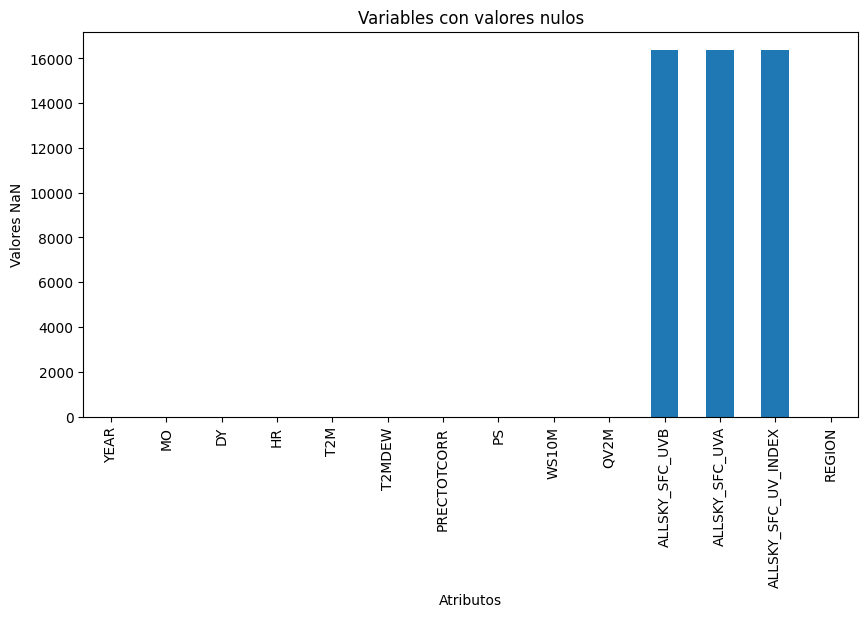

In [9]:
df_weather.isna().sum().plot(kind = 'bar', title = 'Variables con valores nulos', xlabel = 'Atributos', ylabel = 'Valores NaN', figsize = (10, 5))

In [10]:
# Eliminar registros con atributos vacios
df_weather = df_weather.dropna()
df_weather

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION
0,2021,12,31,18,18.93,16.27,0.00,88.65,0.80,13.18,0.00,0.00,0.00,GUATEMALA
1,2021,12,31,19,18.33,16.01,0.00,88.71,0.12,12.94,0.00,0.00,0.00,GUATEMALA
2,2021,12,31,20,17.71,15.60,0.00,88.74,0.58,12.63,0.00,0.00,0.00,GUATEMALA
3,2021,12,31,21,17.33,15.07,0.00,88.75,1.11,12.15,0.00,0.00,0.00,GUATEMALA
4,2021,12,31,22,16.71,14.48,0.00,88.72,1.49,11.72,0.00,0.00,0.00,GUATEMALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191995,2022,12,1,13,27.33,19.80,0.11,94.34,6.10,15.38,1.17,40.83,6.08,JUTIAPA
191996,2022,12,1,14,27.19,20.06,0.14,94.28,5.92,15.69,0.73,31.55,3.62,JUTIAPA
191997,2022,12,1,15,26.71,20.15,0.18,94.27,5.84,15.75,0.28,18.88,1.40,JUTIAPA
191998,2022,12,1,16,25.62,20.48,0.21,94.30,5.24,16.11,0.03,6.55,0.17,JUTIAPA


In [11]:
dfplot = df_weather.groupby(['YEAR', 'MO', 'DY', 'HR'], as_index = False).sum(numeric_only = True)
#dfplot.loc[dfplot['PS'] < 1500]
df_weather.loc[(df_weather['YEAR'] == 2022) & (df_weather['MO'] == 1) & (df_weather['DY'] == 18) & (df_weather['HR'] == 10)]

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION
424,2022,1,18,10,23.68,12.22,0.00,88.91,3.24,10.01,1.27,42.74,6.58,GUATEMALA
9184,2022,1,18,10,18.57,13.30,0.01,90.10,3.94,10.62,1.27,42.74,6.58,EL PROGRESO
17944,2022,1,18,10,23.68,12.22,0.00,88.91,3.24,10.01,1.27,42.74,6.58,SACATEPEQUEZ
26704,2022,1,18,10,23.68,12.22,0.00,88.91,3.24,10.01,1.27,42.74,6.58,CHIMALTENANGO
35464,2022,1,18,10,27.63,18.26,0.00,99.86,2.35,13.24,1.23,42.87,6.35,ESCUINTLA
44224,2022,1,18,10,28.02,15.60,0.00,97.33,2.95,11.47,1.27,42.74,6.58,SANTA ROSA
52984,2022,1,18,10,25.64,14.65,0.00,91.99,1.38,11.47,1.23,42.87,6.35,SOLOLA
61744,2022,1,18,10,17.76,10.00,0.00,79.58,1.52,9.64,1.22,41.52,6.35,TOTONICAPAN
70504,2022,1,18,10,21.08,14.39,0.00,85.36,1.75,12.15,1.23,42.87,6.35,QUETZALTENANGO
79264,2022,1,18,10,25.64,14.65,0.00,91.99,1.38,11.47,1.23,42.87,6.35,SUCHITEPEQUEZ


### Inspección visual del repositorio

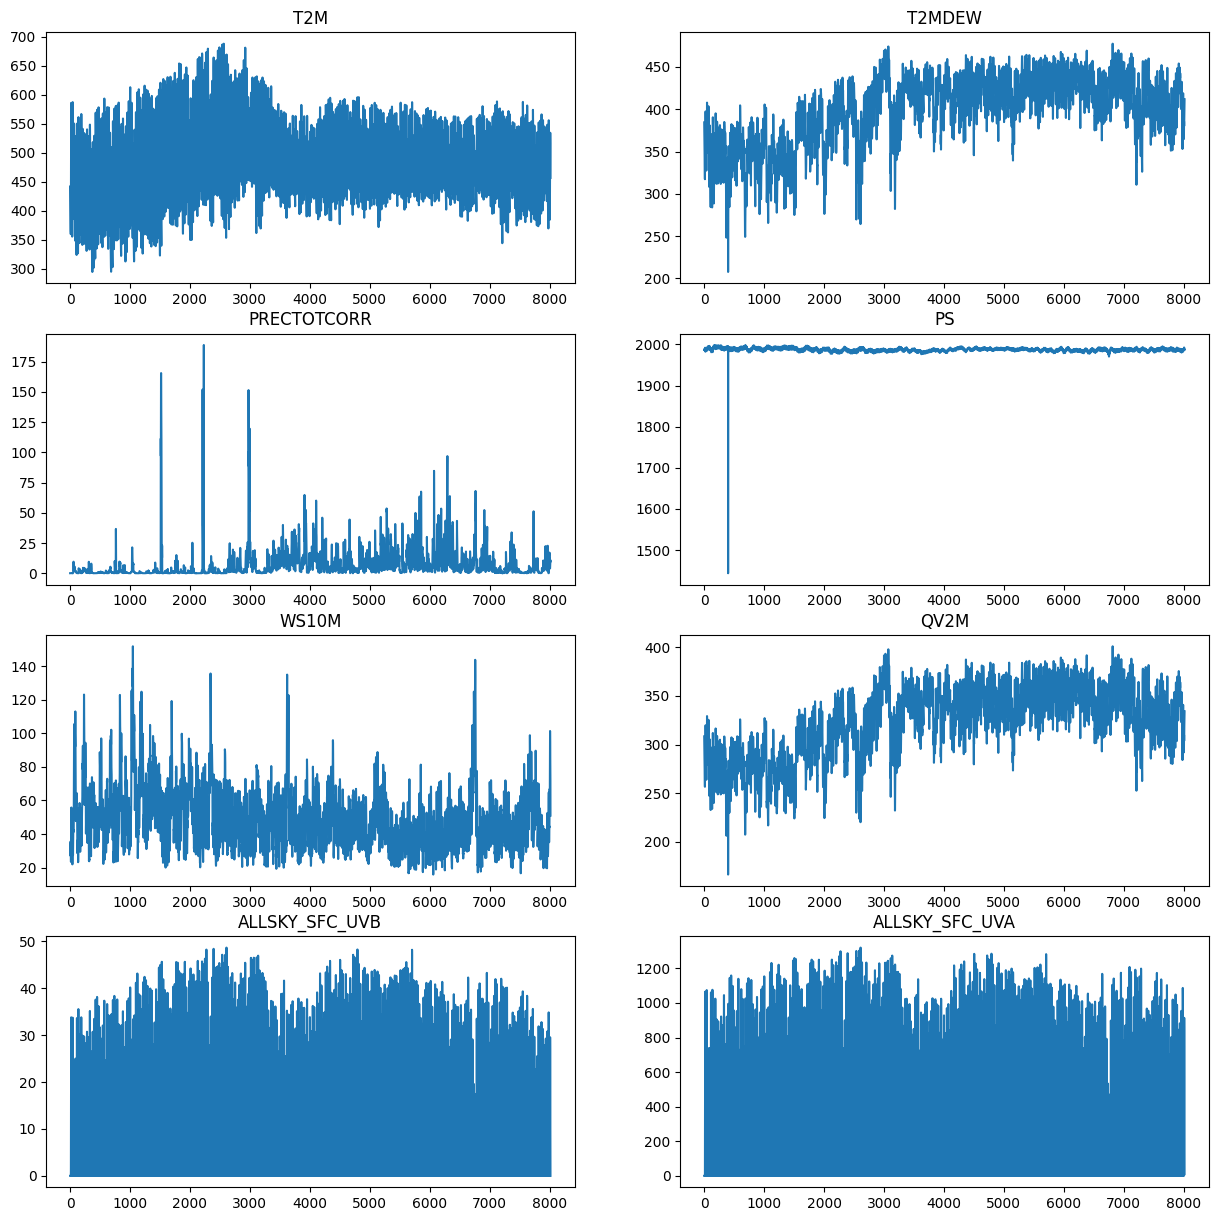

In [12]:
nrow, ncol = 4, 2
fig,  axes = plt.subplots(nrow, ncol, figsize = (15, 15))

count = 4 # First numeric attribute
for r in range(nrow):
    for c in range(ncol):
        #dfplot = df_weather.loc[df_weather['REGION'] == 'JALAPA', :]
        dfplot = df_weather.groupby(['YEAR', 'MO', 'DY', 'HR'], as_index = False).sum(numeric_only = True)
        dfplot.iloc[:, count].plot(ax = axes[r, c])
        axes[r, c].set_title(df_weather.columns[count])
        count += 1

## Exploración de la fuente secundaria

### Importar dataset regional anual
Se evaluará el repositorio `Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)`, cuyo objetivo es registrar la porción de inversiones en salud sobre el PIB para cada país, siendo seleccionado porque permite establecer un nivel de compromiso de los gobiernos por mejorar la calidad de vida humana y, para este caso, frenar la acelarada aparición de nuevos casos de COVID-19. El dataset se encuentra disponible en: https://apps.who.int/gho/data/view.main.GHEDCHEGDPSHA2011v

In [13]:
# Se importan los datos del repositorio de WHO sobre el porcentaje de inversión en salud con respecto al PIB
dnrg = pd.read_csv('C:/Users/Sebastian/Desktop/DatosDemanda.csv')
dnrg

,DEPARTAMENTO,%TG 01-21,01-21,%TG 02-21,02-21,%TG 03-21,03-21,%TG 04-21,04-21,%TG 05-21,...,%TG 08-22,08-22,%TG 09-22,09-22,%TG 10-22,10-22,%TG 11-22,11-22,%TG 12-22,12-22
0,ALTA VERAPAZ,0.0166,196.65,0.0162,14.17,0.0160,15.70,0.0164,15.61,0.0159,...,0.0171,17.25,0.0170,16.49,0.0169,16.88,0.0167,16.48,0.0169,16.77
1,BAJA VERAPAZ,0.0081,95.75,0.0076,6.62,0.0081,7.97,0.0083,7.94,0.0081,...,0.0070,7.11,0.0081,7.87,0.0081,8.08,0.0083,8.20,0.0088,8.73
2,CHIMALTENANGO,0.0289,341.27,0.0283,24.71,0.0285,28.01,0.0278,26.48,0.0276,...,0.0294,29.66,0.0293,28.42,0.0293,29.25,0.0287,28.37,0.0291,28.90
3,CHIQUIMULA,0.0177,209.54,0.0175,15.24,0.0178,17.47,0.0181,17.25,0.0185,...,0.0179,18.10,0.0174,16.94,0.0175,17.44,0.0173,17.01,0.0177,17.62
4,EL PETEN,0.0188,221.95,0.0170,14.82,0.0183,17.98,0.0203,19.27,0.0197,...,0.0192,19.42,0.0197,19.16,0.0195,19.48,0.0191,18.82,0.0187,18.55
5,EL PROGRESO,0.0345,408.40,0.0346,30.18,0.0342,33.53,0.0354,33.64,0.0380,...,0.0348,35.12,0.0344,33.43,0.0346,34.47,0.0330,32.57,0.0354,35.21
6,EL QUICHE,0.0115,135.58,0.0111,9.64,0.0110,10.78,0.0111,10.53,0.0109,...,0.0111,11.26,0.0116,11.24,0.0117,11.62,0.0116,11.47,0.0118,11.76
7,ESCUINTLA,0.1139,1347.46,0.1218,106.24,0.1237,121.47,0.1196,113.74,0.1151,...,0.1118,112.94,0.1080,104.87,0.1103,110.08,0.1140,112.49,0.1103,109.55
8,GUATEMALA,0.4120,4872.21,0.4125,359.70,0.4088,401.31,0.4037,384.04,0.4126,...,0.4150,419.21,0.4153,403.34,0.4146,413.60,0.4124,407.07,0.4041,401.47
9,HUEHUETENANGO,0.0402,475.09,0.0409,35.68,0.0409,40.17,0.0406,38.62,0.0401,...,0.0399,40.33,0.0403,39.14,0.0408,40.75,0.0406,40.11,0.0423,42.04


#### Preparación de los datos
Se realizan correcciones en la estructura del repositorio. Primero, se elimina la primera fila debido a que contienen los numbres de los atributos. Más adelante, se recuperan los datos correspondientes al año 2020, que coinciden con las fechas presentadas en el dataset principal. Como se hizo para el primer repositorio, se eliminan los filas con valores incompletos. Finalmente, se efectúa la combinación de `df2` y `dfCHE`.

In [14]:
# Dividir la columna de enero 2021 entre 10 unidades para ajustar un posible error en el registro 
dnrg.loc[:, '01-21'] = dnrg.loc[:, '01-21'] / 12.2
dnrg['01-21']

# Corregir el nombre de la division con indice 16
dnrg.iloc[16, 0] = 'SAN MARCOS'
dnrg.iloc[4, 0] = 'PETEN'
dnrg.iloc[6, 0] = 'QUICHE'
print(dnrg['DEPARTAMENTO'].unique())

['ALTA VERAPAZ' 'BAJA VERAPAZ' 'CHIMALTENANGO' 'CHIQUIMULA' 'PETEN'
 'EL PROGRESO' 'QUICHE' 'ESCUINTLA' 'GUATEMALA' 'HUEHUETENANGO' 'IZABAL'
 'JALAPA' 'JUTIAPA' 'QUEZALTENANGO' 'RETALHULEU' 'SACATEPEQUEZ'
 'SAN MARCOS' 'SANTA ROSA' 'SOLOLA' 'SUCHITEPEQUEZ' 'TOTONICAPAN' 'ZACAPA']


In [15]:
# Elaboracion de DF temporales para obtener el formato de agregación esperado
# Intervalo de fechas desde enero 2021 hasta diciembre 2022
date = pd.date_range('2021-01-01', periods = 24, freq = 'M')
# Listado de regiones estudiadas
region = pd.DataFrame(dnrg['DEPARTAMENTO'].unique())
dnrg1 = pd.DataFrame({'YEAR': date.year, 'MO': date.month})

# Combinacion de fechas con divisiones administrativas
dnrg2 = pd.merge(dnrg1, region, how = 'cross')
dnrg2.columns.values[2] = 'REGION'

In [16]:
# Apilar resultados de demanda electrica en una columnas generales (hechos)
tg = pd.DataFrame(dnrg.iloc[:,1::2].stack()).sort_index(axis = 0, level = 1).reset_index(drop = True)
demand = pd.DataFrame(dnrg.iloc[:,2::2].stack()).sort_index(axis = 0, level = 1).reset_index(drop = True)

# Editar registros anómalos
tg.loc[243] = dnrg.iloc[1, 23]
tg.loc[262] = dnrg.iloc[20, 23]

dnrgf = dnrg2
dnrgf['%TG'] = tg
dnrgf['ENERGY'] = demand
dnrgf.loc[dnrgf['YEAR'] > 2021, :]

,YEAR,MO,REGION,%TG,ENERGY
264,2022,1,ALTA VERAPAZ,0.0159,15.58
265,2022,1,BAJA VERAPAZ,0.0080,7.83
266,2022,1,CHIMALTENANGO,0.0285,28.02
267,2022,1,CHIQUIMULA,0.0180,17.68
268,2022,1,PETEN,0.0183,17.97
...,...,...,...,...,...
523,2022,12,SANTA ROSA,0.0232,23.07
524,2022,12,SOLOLA,0.0115,11.40
525,2022,12,SUCHITEPEQUEZ,0.0325,32.31
526,2022,12,TOTONICAPAN,0.0068,6.71


<AxesSubplot: xlabel='YEAR,MO'>

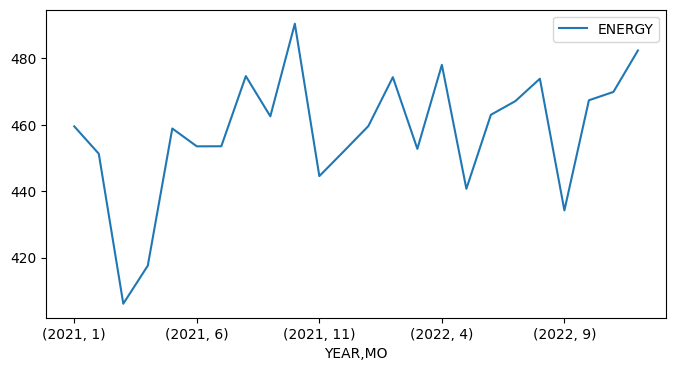

In [17]:
dnrgf.loc[(dnrgf['REGION'] != 'ESCUINTLA') & (dnrgf['REGION'] != 'GUATEMALA'), ['YEAR', 'MO', 'ENERGY']].groupby(['YEAR', 'MO']).sum(numeric_only = True).plot(figsize = (8, 4))

### Importar dataset horario nacional

In [18]:
# Read country hourly dataset
df_nrgh = pd.read_csv("C:/Users/Sebastian/Desktop/DemandaHoras.csv")

#### Vista previa

In [19]:
df_nrgh.head()

,Fecha,Hora,Demanda Local,Interconexion
0,01/01/2022,1,1114.21,-20.06
1,01/01/2022,2,977.39,-2.73
2,01/01/2022,3,888.09,65.16
3,01/01/2022,4,886.84,65.48
4,01/01/2022,5,890.79,38.99


In [20]:
df_nrgh[['DY', 'MO', 'YEAR']] = df_nrgh['Fecha'].str.split('/', expand = True)
df_nrgh

,Fecha,Hora,Demanda Local,Interconexion,DY,MO,YEAR
0,01/01/2022,1,1114.21,-20.06,01,01,2022
1,01/01/2022,2,977.39,-2.73,01,01,2022
2,01/01/2022,3,888.09,65.16,01,01,2022
3,01/01/2022,4,886.84,65.48,01,01,2022
4,01/01/2022,5,890.79,38.99,01,01,2022
...,...,...,...,...,...,...,...
8827,03/01/2023,20,1788.40,-396.85,03,01,2023
8828,03/01/2023,21,1691.98,-386.34,03,01,2023
8829,03/01/2023,22,1449.07,-202.48,03,01,2023
8830,03/01/2023,23,1301.51,25.18,03,01,2023


In [21]:
convert_dict = {'YEAR': int, 'MO': int, 'DY': int, 'Hora': int}
df_nrgh = df_nrgh.astype(convert_dict)

### Combinar los dataframes en un mismo conjunto de datos 

In [22]:
nrg_tmp = pd.merge(dnrgf, df_nrgh, on = ['YEAR', 'MO'])
nrg_tmp

,YEAR,MO,REGION,%TG,ENERGY,Fecha,Hora,Demanda Local,Interconexion,DY
0,2022,1,ALTA VERAPAZ,0.0159,15.58,01/01/2022,1,1114.21,-20.06,1
1,2022,1,ALTA VERAPAZ,0.0159,15.58,01/01/2022,2,977.39,-2.73,1
2,2022,1,ALTA VERAPAZ,0.0159,15.58,01/01/2022,3,888.09,65.16,1
3,2022,1,ALTA VERAPAZ,0.0159,15.58,01/01/2022,4,886.84,65.48,1
4,2022,1,ALTA VERAPAZ,0.0159,15.58,01/01/2022,5,890.79,38.99,1
...,...,...,...,...,...,...,...,...,...,...
192715,2022,12,ZACAPA,0.0310,30.77,31/12/2022,20,1658.37,0.07,31
192716,2022,12,ZACAPA,0.0310,30.77,31/12/2022,21,1461.83,23.78,31
192717,2022,12,ZACAPA,0.0310,30.77,31/12/2022,22,1323.06,120.17,31
192718,2022,12,ZACAPA,0.0310,30.77,31/12/2022,23,1237.98,224.68,31


In [23]:
df_nrg_hour = pd.DataFrame({"YEAR": nrg_tmp['YEAR'], "MO": nrg_tmp['MO'], "DY": nrg_tmp['DY'], "HR": nrg_tmp['Hora'], "REGION": nrg_tmp['REGION'], "ENERGY": nrg_tmp['%TG'] * nrg_tmp['Demanda Local'], "INTERCXN": nrg_tmp['%TG'] * nrg_tmp['Interconexion']})
df_nrg_hour.head()

,YEAR,MO,DY,HR,REGION,ENERGY,INTERCXN
0,2022,1,1,1,ALTA VERAPAZ,17.715939,-0.318954
1,2022,1,1,2,ALTA VERAPAZ,15.540501,-0.043407
2,2022,1,1,3,ALTA VERAPAZ,14.120631,1.036044
3,2022,1,1,4,ALTA VERAPAZ,14.100756,1.041132
4,2022,1,1,5,ALTA VERAPAZ,14.163561,0.619941


### Análisis estadístico descriptivo numérico
Los atributos contienen tanto valores positivos como negativos. Un valor negativo puede interpretarse como un descarte del registro debido a que se halló una causa distinta de su enfermedad. Casi todos los atributos numéricos (no categóricos) muestran un recuento de 61,900 instancias, con excepción de `popData2019` y `Cumulative_number_for_14_days_of_COVID-19_cases_per_100000`, con __123__ y __2,879__ registros no disponibles respectivamente. 

In [24]:
# Resumen de medidas de tendencia central y dispersion para cada clase
df_nrg_hour.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
YEAR,192720.0,2022.000000,0.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.00000
MO,192720.0,6.526027,3.447860,1.000000,4.000000,7.000000,10.000000,12.00000
DY,192720.0,15.720548,8.796270,1.000000,8.000000,16.000000,23.000000,31.00000
HR,192720.0,12.500000,6.922205,1.000000,6.750000,12.500000,18.250000,24.00000
ENERGY,192720.0,63.221729,118.367514,5.117473,19.560120,32.642842,50.431654,801.36085
INTERCXN,192720.0,-1.798197,15.494127,-210.436992,-3.411218,-0.531377,1.762702,149.79010


### Determinar si existen valores nulos
Los atributos `geoid`, `contryterritoryCode`, `popData2019` y `Cumulative_number_for_14_days_of_COVID-19_cases_per_100000` poseen registros sin valor disponible. Se decide descartar los renglones con un atributo o más que contengan valores `NaN`.

In [25]:
# Encontrar valores nulos
df_nrg_hour.isna().sum()

YEAR        0
MO          0
DY          0
HR          0
REGION      0
ENERGY      0
INTERCXN    0
dtype: int64

### Inspección visual del dataset combinado

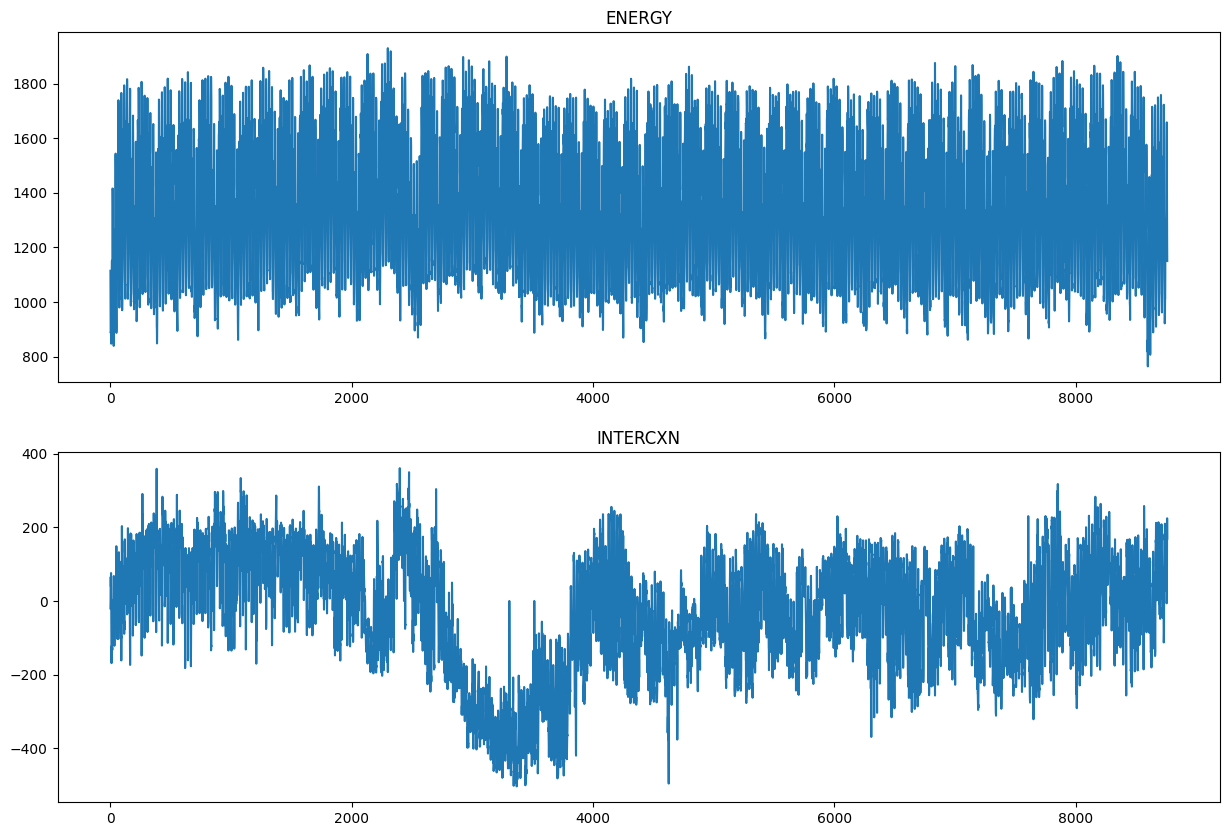

In [26]:
nrow, ncol = 2, 1
fig,  axes = plt.subplots(nrow, ncol, figsize = (15, 10))

count = 4 # First numeric attribute
for r in range(nrow):
    for c in range(ncol):
        #dfplot = df_nrg_hour.loc[df_nrg_hour['REGION'] == 'SANTA ROSA', :]
        dfplot = df_nrg_hour.groupby(['YEAR', 'MO', 'DY', 'HR'], as_index = False).sum(numeric_only = True)
        dfplot.iloc[:, count].plot(ax = axes[r])
        axes[r].set_title(df_nrg_hour.columns[count + 1])
        count += 1

<Figure size 1600x500 with 0 Axes>

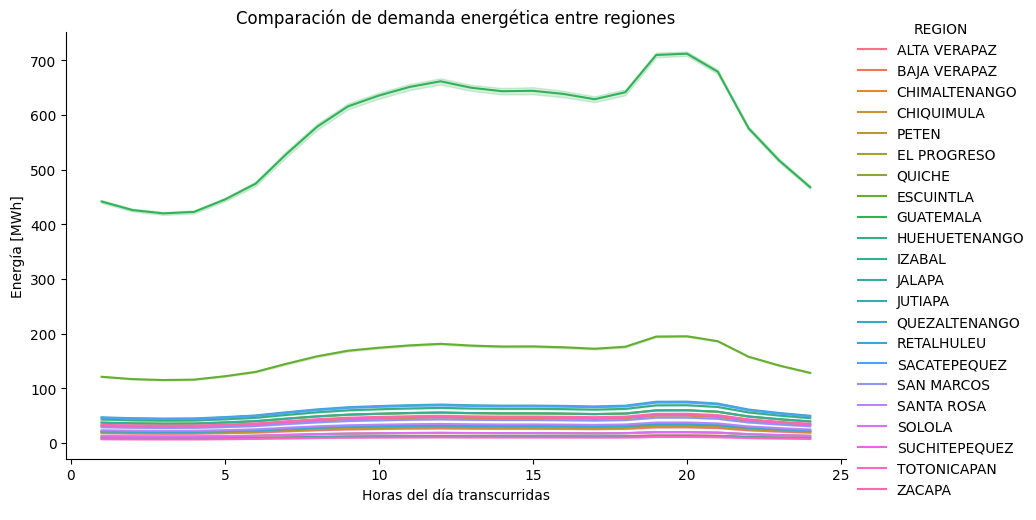

In [27]:
plt.figure(figsize = (16, 5))
sns.relplot(data = df_nrg_hour, x = 'HR', y = 'ENERGY', kind = 'line', hue = 'REGION', height = 5, aspect = 1.75).set(title = 'Comparación de demanda energética entre regiones', ylabel = 'Energía [MWh]', xlabel = 'Horas del día transcurridas' )

## Creación de la fuente final de análisis

In [41]:
# Unificar los datos
dfFinal = pd.merge(df_weather, df_nrg_hour, on = ['YEAR', 'MO', 'DY', 'HR', 'REGION'], how = "inner")
dfFinal

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION,ENERGY,INTERCXN
0,2022,1,1,1,14.94,13.48,0.00,88.62,2.03,10.93,0.00,0.00,0.00,GUATEMALA,460.057309,-8.282774
1,2022,1,1,2,14.52,13.55,0.00,88.60,2.04,10.99,0.00,0.00,0.00,GUATEMALA,403.564331,-1.127217
2,2022,1,1,3,14.45,13.69,0.00,88.61,1.93,11.05,0.00,0.00,0.00,GUATEMALA,366.692361,26.904564
3,2022,1,1,4,14.32,13.81,0.00,88.65,1.83,11.17,0.00,0.00,0.00,GUATEMALA,366.176236,27.036692
4,2022,1,1,5,14.15,13.90,0.00,88.70,1.69,11.23,0.00,0.00,0.00,GUATEMALA,367.807191,16.098971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161186,2022,12,1,13,27.33,19.80,0.11,94.34,6.10,15.38,1.17,40.83,6.08,JUTIAPA,32.602200,-2.663200
161187,2022,12,1,14,27.19,20.06,0.14,94.28,5.92,15.69,0.73,31.55,3.62,JUTIAPA,33.003800,-2.891400
161188,2022,12,1,15,26.71,20.15,0.18,94.27,5.84,15.75,0.28,18.88,1.40,JUTIAPA,32.508400,-3.026200
161189,2022,12,1,16,25.62,20.48,0.21,94.30,5.24,16.11,0.03,6.55,0.17,JUTIAPA,33.331600,-3.094000


In [42]:
# Copy dataframe for further analysis
dftemp = dfFinal
dftempg = dfFinal

#### Identificar tipos de datos
Los atributos `cases` y `deaths` siguen siendo variables enteras, mientras que `gasto` es de tipo objeto, por lo se procede a truncar para que coincida con el formato flotante (decimal). Estas son las descripciones para cada uno de los atributos:
<table>
  <tr>
    <th>Atributo</th>
    <th>Descripción</th>
  </tr>
  <tr>
    <td>cases</td>
    <td>Total de contagios por país</td>
  </tr>
  <tr>
    <td>deaths</td>
    <td>Total de defunciones por país</td>
  </tr>
    <tr>
    <td>popData2019</td>
    <td>Tamaño de la población para el año 2019</td>
  </tr>
    <tr>
    <td>gasto</td>
    <td>Porcentaje del PIB que corresponde en inversiones hacia el sector de salud para cada país</td>
  </tr>
    <tr>
    <td>tasa_muertes</td>
    <td>Unidad porcentual relativa que indica porción de muertes por cada habitante en un país</td>
  </tr>
</table>

In [30]:
dfFinal.dtypes

YEAR                     int64
MO                       int64
DY                       int64
HR                       int64
T2M                    float64
T2MDEW                 float64
PRECTOTCORR            float64
PS                     float64
WS10M                  float64
QV2M                   float64
ALLSKY_SFC_UVB         float64
ALLSKY_SFC_UVA         float64
ALLSKY_SFC_UV_INDEX    float64
REGION                  object
ENERGY                 float64
INTERCXN               float64
dtype: object

#### Determinar si existen valores nulos
Los atributos `popData2019` y `gastos` poseen registros con celdas vacías. Se decide descartar los renglones con un atributo o más que contengan valores `NaN`.

In [31]:
# Encontrar valores nulos
dfFinal.isna().sum()

YEAR                   0
MO                     0
DY                     0
HR                     0
T2M                    0
T2MDEW                 0
PRECTOTCORR            0
PS                     0
WS10M                  0
QV2M                   0
ALLSKY_SFC_UVB         0
ALLSKY_SFC_UVA         0
ALLSKY_SFC_UV_INDEX    0
REGION                 0
ENERGY                 0
INTERCXN               0
dtype: int64

In [32]:
# Eliminar registros con atributos vacios
dfFinal = dfFinal.dropna()
dfFinal

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION,ENERGY,INTERCXN
0,2022,1,1,1,14.94,13.48,0.00,88.62,2.03,10.93,0.00,0.00,0.00,GUATEMALA,460.057309,-8.282774
1,2022,1,1,2,14.52,13.55,0.00,88.60,2.04,10.99,0.00,0.00,0.00,GUATEMALA,403.564331,-1.127217
2,2022,1,1,3,14.45,13.69,0.00,88.61,1.93,11.05,0.00,0.00,0.00,GUATEMALA,366.692361,26.904564
3,2022,1,1,4,14.32,13.81,0.00,88.65,1.83,11.17,0.00,0.00,0.00,GUATEMALA,366.176236,27.036692
4,2022,1,1,5,14.15,13.90,0.00,88.70,1.69,11.23,0.00,0.00,0.00,GUATEMALA,367.807191,16.098971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161186,2022,12,1,13,27.33,19.80,0.11,94.34,6.10,15.38,1.17,40.83,6.08,JUTIAPA,32.602200,-2.663200
161187,2022,12,1,14,27.19,20.06,0.14,94.28,5.92,15.69,0.73,31.55,3.62,JUTIAPA,33.003800,-2.891400
161188,2022,12,1,15,26.71,20.15,0.18,94.27,5.84,15.75,0.28,18.88,1.40,JUTIAPA,32.508400,-3.026200
161189,2022,12,1,16,25.62,20.48,0.21,94.30,5.24,16.11,0.03,6.55,0.17,JUTIAPA,33.331600,-3.094000


#### Columna de clasificación
Se crea una columna que contenga el porcentaje de decesos relativo al tamaño de la ploblación para cada país. Por tanto, se obtiene la razón entre `deaths` y `popData2019`. Además, se incluye una clasificación del gasto `clase_gasto` de acuerdo con el nivel de inversión para cada país. <p>Establecer clases de porcentajes </p>
<ul>
<li>De 0 a 5, bajo = 0</li>
<li>De 6 a 10, medio = 1</li>
<li>De 11 a 16, alto = 2</li>
</ul>

In [45]:
# Drop columns related with time and location
#dfFinal = dfFinal.drop(columns = ['YEAR', 'MO',  'DY', 'HR', 'REGION'], errors = 'ignore')  # Used when it may be necessary to evaluate REGIONS
dfFinal = dfFinal.drop(columns = ['YEAR', 'MO',  'DY', 'HR'], errors = 'ignore')

dfFinal.head(10)

,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,REGION,ENERGY,INTERCXN
0,14.94,13.48,0.0,88.62,2.03,10.93,0.00,0.00,0.00,GUATEMALA,460.057309,-8.282774
1,14.52,13.55,0.0,88.60,2.04,10.99,0.00,0.00,0.00,GUATEMALA,403.564331,-1.127217
2,14.45,13.69,0.0,88.61,1.93,11.05,0.00,0.00,0.00,GUATEMALA,366.692361,26.904564
3,14.32,13.81,0.0,88.65,1.83,11.17,0.00,0.00,0.00,GUATEMALA,366.176236,27.036692
4,14.15,13.90,0.0,88.70,1.69,11.23,0.00,0.00,0.00,GUATEMALA,367.807191,16.098971
5,14.25,14.03,0.0,88.75,1.55,11.29,0.00,0.59,0.00,GUATEMALA,355.692705,31.355626
6,17.62,14.91,0.0,88.82,1.59,11.96,0.05,8.27,0.27,GUATEMALA,349.713913,14.633176
7,20.79,15.37,0.0,88.87,1.09,12.33,0.34,21.68,1.73,GUATEMALA,350.985645,-17.919860
8,23.17,15.47,0.0,88.88,1.50,12.39,0.81,34.47,4.05,GUATEMALA,394.769561,-55.468986
9,25.05,15.13,0.0,88.83,1.82,12.15,1.23,42.55,6.35,GUATEMALA,440.378495,-69.738810


### Análisis estadístico descriptivo numérico
Los atributos contienen únicamente valores positivos, como resultado de las funciones de agregación. Hay un recuento de 135 países distintos. 

In [59]:
# Resumen de medidas de tendencia central y dispersion para cada clase
dfdescr = dfFinal.describe().transpose()

,count,mean,std,min,25%,50%,75%,max,disper
T2M,161191.0,21.814017,4.610889,6.140000,18.620000,21.900000,25.230000,40.02000,0.211373
T2MDEW,161191.0,18.211893,3.505157,2.110000,15.830000,18.550000,20.740000,26.69000,0.192465
PRECTOTCORR,161191.0,0.304769,0.883582,0.000000,0.010000,0.060000,0.290000,37.30000,2.899192
PS,161191.0,90.585312,5.617084,78.670000,88.430000,91.260000,94.520000,100.06000,0.062009
WS10M,161191.0,2.227256,1.413567,0.010000,1.230000,1.900000,2.870000,12.53000,0.634668
QV2M,161191.0,14.740651,2.490782,5.430000,13.000000,14.830000,16.540000,22.28000,0.168974
ALLSKY_SFC_UVB,161191.0,0.413981,0.615235,0.000000,0.000000,0.010000,0.730000,2.52000,1.486143
ALLSKY_SFC_UVA,161191.0,14.030943,18.167451,0.000000,0.000000,1.630000,28.780000,66.49000,1.294813
ALLSKY_SFC_UV_INDEX,161191.0,2.148782,3.230484,0.000000,0.000000,0.020000,3.730000,14.00000,1.503402
ENERGY,161191.0,63.920551,122.434577,5.117473,19.150794,31.793860,48.835195,801.36085,1.915418


### Análisis estadístico descriptivo gráfico
Primero se observan los niveles de correlación para identificar si existe un nexo significativo entre parejas de los atributos de entrada; especialmente con la variable de salida. El emparejamiento `gasto - tasa_muertes` mantiene una relación proporcionales debil, pero es la más considerable del conjunto de datos.

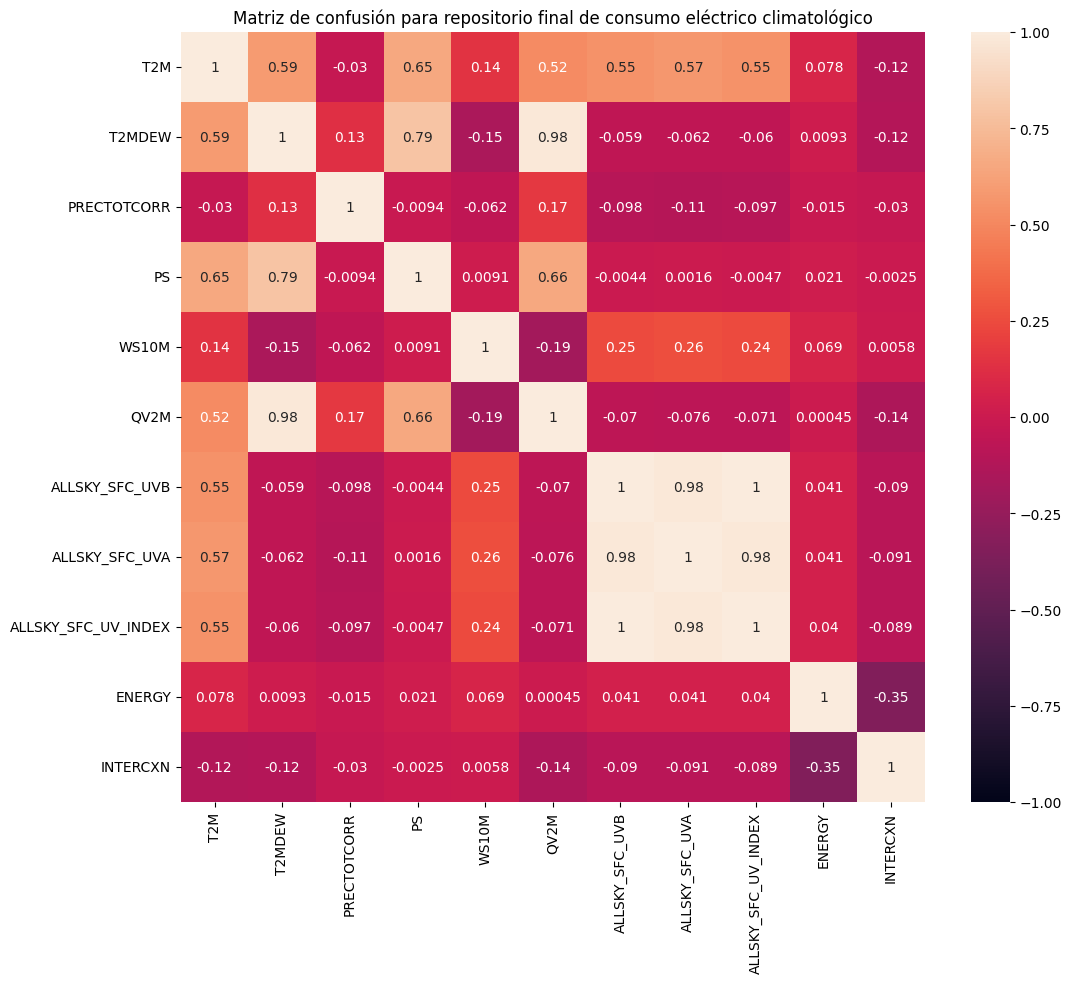

In [47]:
# Explore correlation data among all variables
fig = plt.figure(figsize = (12, 10))
corr_matrix = dfFinal.corr(method = 'pearson', numeric_only = True)
g = sns.heatmap(corr_matrix, vmin = -1, vmax = +1, annot = True)
g.set(title = 'Matriz de confusión para repositorio final de consumo eléctrico climatológico')
plt.show()
# corr_matrix

Luego se muestra una matriz de diagramas de dispersión y de distribución para algunos atributos relevantes. 

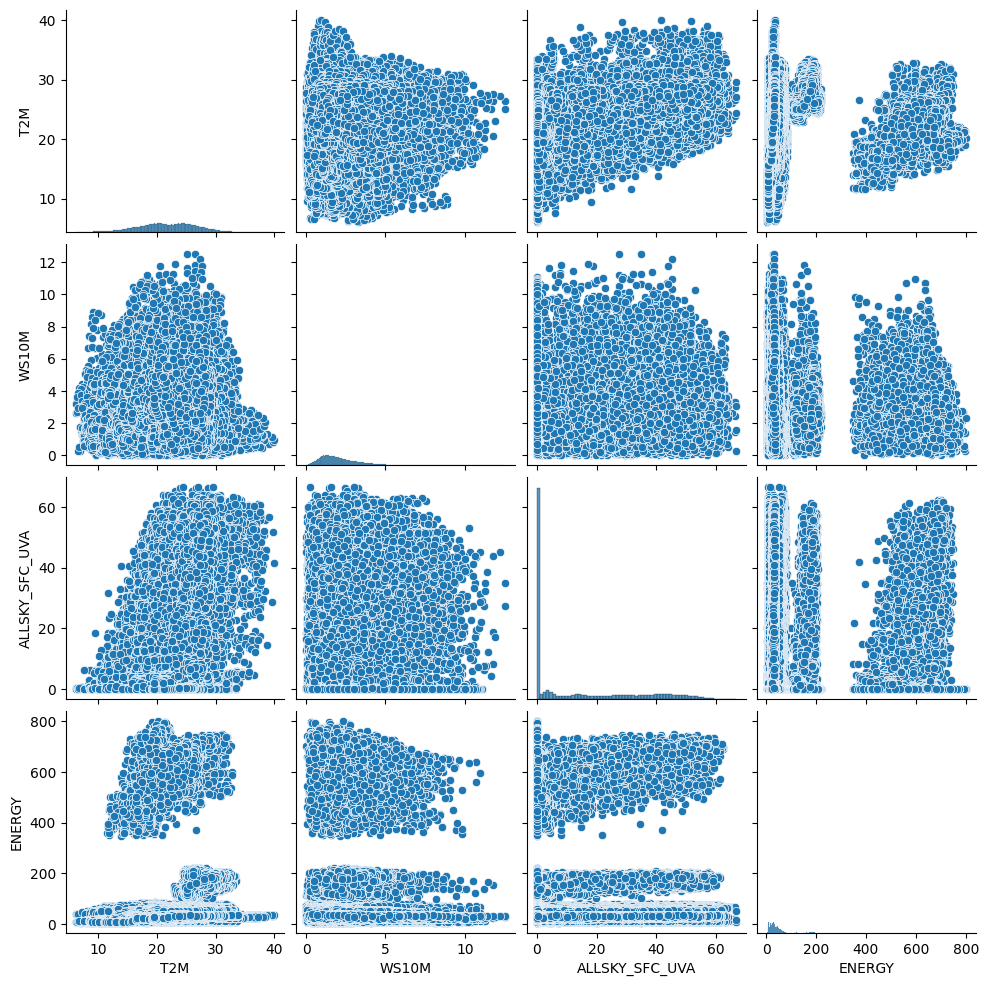

In [42]:
#sns.pairplot(dfFinal[['T2M', 'WS10M', 'ALLSKY_SFC_UVA', 'ENERGY', 'YEAR']], hue = 'YEAR', palette  = 'tab10')
sns.pairplot(dfFinal[['T2M', 'WS10M', 'ALLSKY_SFC_UVA', 'ENERGY', 'REGION']])

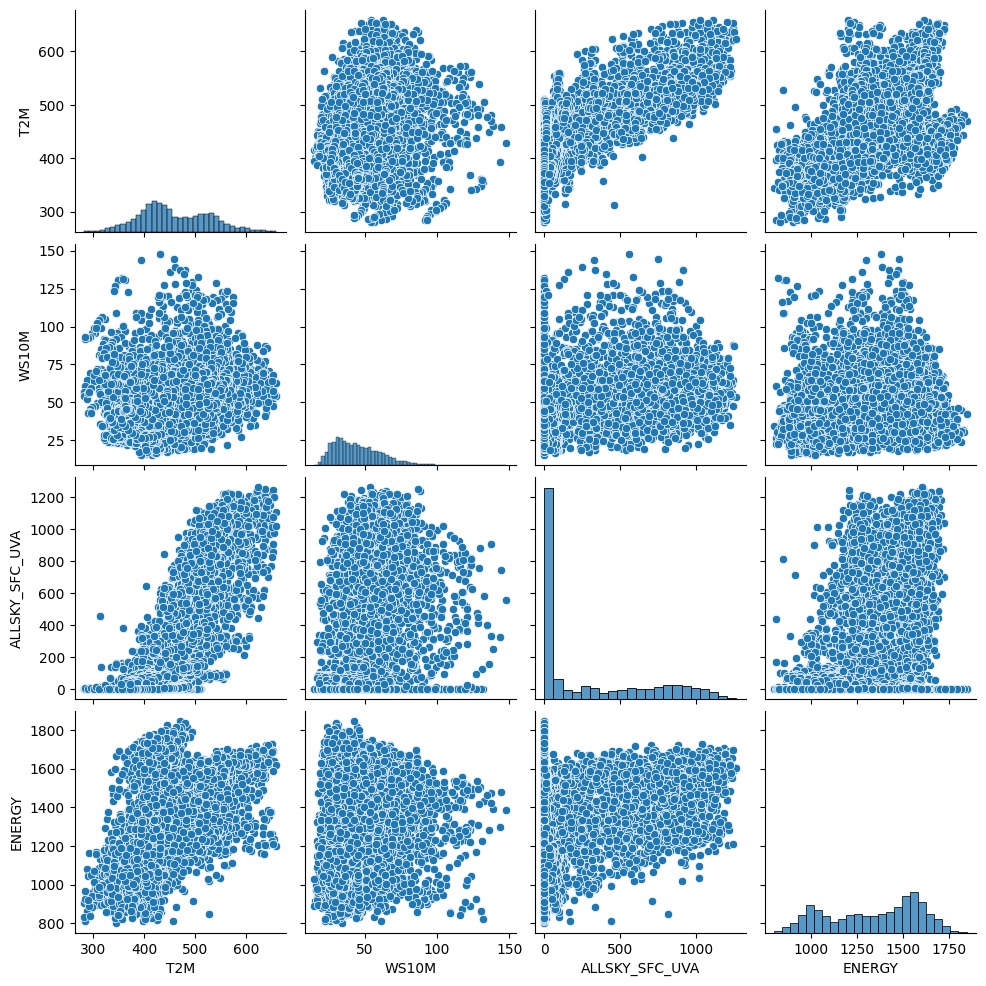

In [44]:
dftempg = dftempg.groupby(['YEAR', 'MO', 'DY', 'HR'], as_index=False).sum()
sns.pairplot(dftempg[['T2M', 'WS10M', 'ALLSKY_SFC_UVA', 'ENERGY']])

[Text(0.5, 1.0, 'Matriz de confusión para repositorio final de consumo eléctrico climatológico')]

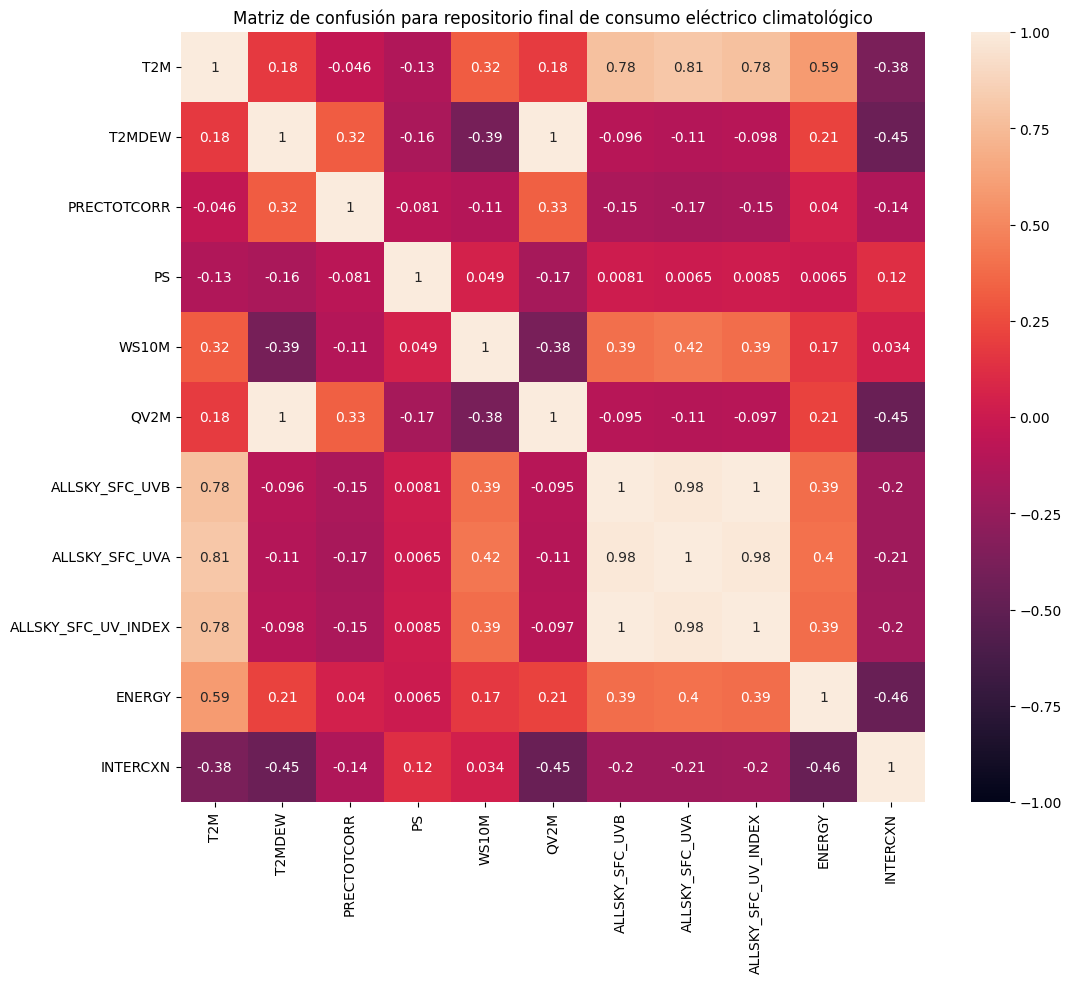

In [55]:
fig = plt.figure(figsize = (12, 10))
corr_matrix = dftempg.drop(columns=['YEAR', 'MO', 'DY', 'HR']).corr(method = 'pearson', numeric_only = True)
g = sns.heatmap(corr_matrix, vmin = -1, vmax = +1, annot = True)
g.set(title = 'Matriz de confusión para repositorio final de consumo eléctrico climatológico')

Se pueden observar valores atípicos dentro del gráfico de cajas y bigotes para el repositorio final. Se observa que la relación de aspecto entre `gasto` y `tasa_muertes` es muy grande. Si existe una relación entre ellos, su sensibilidad es muy elevada que un pequeño cambio en `tasa_muertes` representa un cambio mayor en `gasto`. 

<AxesSubplot: >

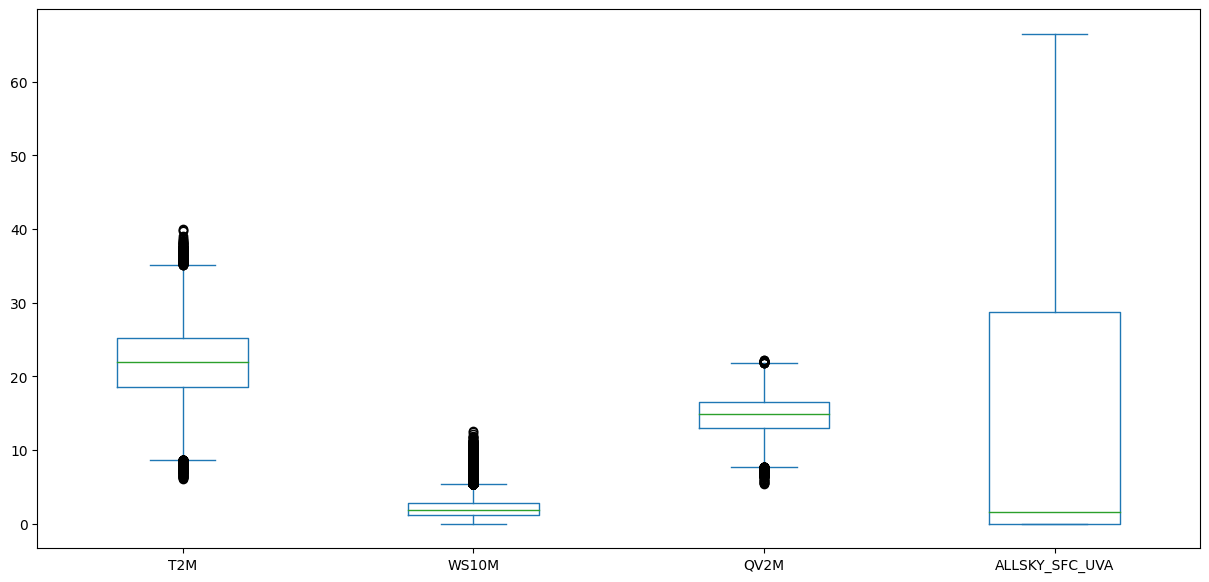

In [123]:
# Graficos de cajas
dfFinal[['T2M', 'WS10M', 'QV2M', 'ALLSKY_SFC_UVA']].plot.box(figsize=(15, 7), showfliers = True)

Se muestra el gráfico de dispersión entre `gasto`, o el porcentaje de inversión en salud dentro del PIB nacional; y `tasa_muertes`, o el porcentaje de defunciones por cada habitante.

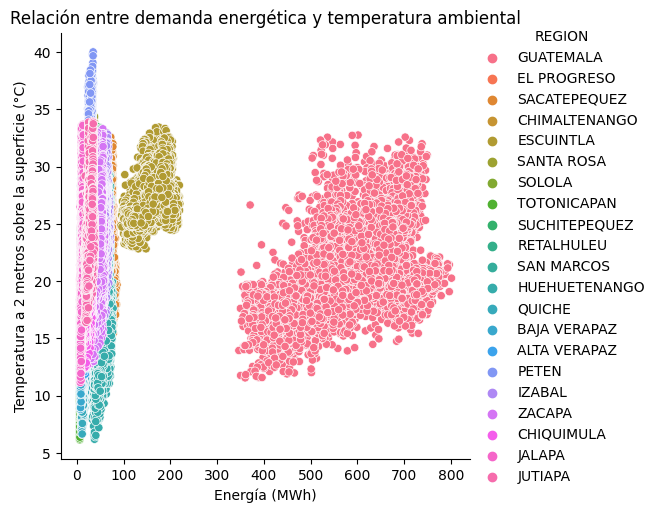

In [122]:
# Comparison between energetic demand and surface temperature
g = sns.relplot(x = 'ENERGY', y = 'T2M', data = dfFinal, hue = 'REGION')
g.set(xlabel = 'Energía (MWh)', ylabel = 'Temperatura a 2 metros sobre la superficie (°C)', title = 'Relación entre demanda energética y temperatura ambiental')
plt.show()

<AxesSubplot: >

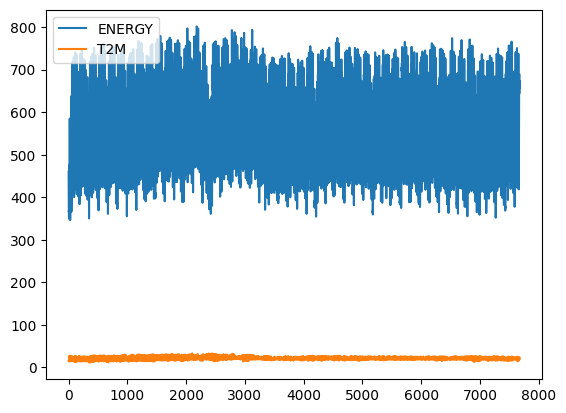

In [124]:
# Compare data scale
dftemp.loc[dftemp['REGION'] == 'GUATEMALA', ['ENERGY', 'T2M']].plot()

<AxesSubplot: xlabel='ENERGY', ylabel='REGION'>

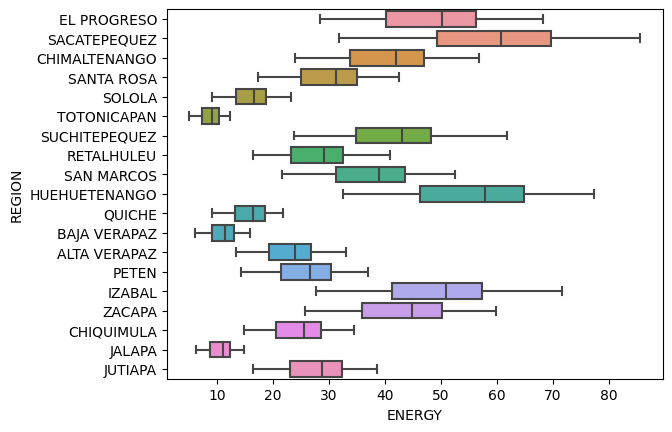

In [125]:
sns.boxplot(data = dftemp.loc[(dftemp['REGION'] != 'GUATEMALA') & (dftemp['REGION'] != 'ESCUINTLA')], x = 'ENERGY', y = 'REGION')

<AxesSubplot: xlabel='ENERGY', ylabel='REGION'>

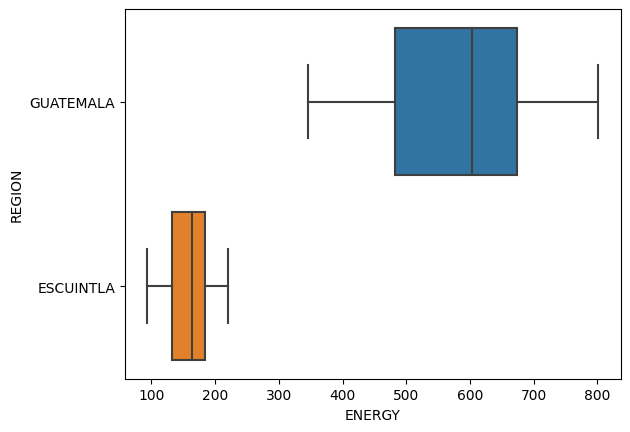

In [126]:
sns.boxplot(data = dftemp.loc[(dftemp['REGION'] == 'GUATEMALA') | (dftemp['REGION'] == 'ESCUINTLA')], x = 'ENERGY', y = 'REGION')

In [127]:
dftemp.loc[(dftemp['REGION'] == 'ESCUINTLA')].groupby('REGION').mean()

,YEAR,MO,DY,HR,T2M,T2MDEW,PRECTOTCORR,PS,WS10M,QV2M,ALLSKY_SFC_UVB,ALLSKY_SFC_UVA,ALLSKY_SFC_UV_INDEX,ENERGY,INTERCXN
REGION,,,,,,,,,,,,,,,
ESCUINTLA,2022.0,6.046906,15.688599,11.993746,27.330188,22.650483,0.288866,99.492022,2.825148,17.505759,0.408151,13.913028,2.11756,159.475657,-5.627934


## Preparación de los datos
Primero, se divide la columna de salida de las variables de entrada. Luego, se transforma los países de categorías a números ordinales (utilizando Label Encoder) y finalmente se escalan los datos para que presente un rango de dimensiones similar.


#### Normalización y estandarización de repositorios

In [128]:
def SplitNormalizer(name, X, y):
    #Define train and test data with 80:20 ratio proportion 
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)
    print(name, ": Entrenamiento: ", X_train.shape[0], " instancias; Prueba: ", Y_test.shape[0], " instancias")

    # Scale input data
    scaler = prep.StandardScaler()
    scaleX_train = scaler.fit_transform(X_train)
    scaleX_test = scaler.fit_transform(X_test)

    ## Normalize input data
    norm = prep.MinMaxScaler()
    normX_train = norm.fit_transform(scaleX_train)
    normX_test = norm.fit_transform(scaleX_test)

    return [normX_train, normX_test, Y_train, Y_test]

#### Creación del modelo
La DNN está conformada por una capa de entrada, 2 capas intermedias y una capa de salida; casi todas con 64 unidades de procesamiento menos la capa final. La función de activación empleada para este ejemplo es la Activación de Unidades Lineales Rectificadas (`relu`), efectiva por mantener una buena relación de rendimiento en procesamiento y exactitud en los resultados <a href="https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu">(Google Developers, 2022)</a>. Con respecto a la compilación del modelo, se empleó un algoritmo RMSprop que mantiene una media móvil de las gradiente matriciales, conveniente para construir regresion multivariable <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop">(Google Developers, 2022)</a>. 

In [129]:
def build_model(train_ds, hp_units, hp_lr):
    keras.backend.clear_session()

    model = keras.Sequential([
        layers.Dense(units=hp_units, activation="relu", input_shape = [len(train_ds[0])]),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])

    optimizer = keras.optimizers.RMSprop(learning_rate=hp_lr)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ["mae", "mse"])

    return model

#### Gráficas del rendimiento del modelo

In [131]:
# Error evolution graph
def plot_history(history, unit, m_name):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    plt.suptitle(m_name)

    ax[0].plot(hist["epoch"], hist["mae"], label = "Entrenamiento")
    ax[0].plot(hist["epoch"], hist["val_mae"], label = "Validación")
    ax[0].set_ylabel("Error Absoluto Medio [{}]".format(unit))

    ax[1].plot(hist["epoch"], hist["mse"], label = "Entrenamiento")
    ax[1].plot(hist["epoch"], hist["val_mse"], label = "Validación")
    ax[1].set_ylabel("Error Cuadrático Medio [${}^2$]".format(unit))

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    
    fig.add_subplot(1, 1, 1, frame_on = False)
    fig.legend(lines, labels, loc = 'upper right', bbox_to_anchor = (0.967, 0.867))
    plt.tick_params(labelcolor = "none", bottom = False, left = False)
    plt.xlabel("Época")
    plt.tight_layout()
    plt.show()

In [132]:
def plot_predict_chart(name, unit, y_test, y_pred):
    plt.figure(figsize = (5, 5))
    #plt.title('Ajuste del modelo {}'.format(name.lower()))

    plt.grid()
    plt.scatter(y_test, y_pred)
    plt.plot([0, 25], [0, 25])
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([-1, 1000], [-1, 1000])

    plt.xlabel('Valores verdaderos [{}]'.format(unit))
    plt.ylabel('Predicciones [{}]'.format(unit))
    plt.show()

In [133]:
def plot_error_histogram(name, unit, y_test, y_pred):
    plt.figure(figsize = (5, 5))
    #plt.title('Error predictivo del modelo {}'.format(name.lower()))

    error = y_pred.flatten() - y_test
    plt.hist(error, bins = 18)

    plt.xlabel('Error predictivo [{}]'.format(unit))
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

#### Entrenamiento con interrupción para red neuronal con 100 épocas 

Se procede a entrenar el modelo DNN con 100 épocas. Las métricas de rendimiento seleccionadas para el modelo son el error absoluto medio ($MAE$) y error cuadrático medio ($MSE$).
<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
<b>IMPORTANTE:</b> El modelo es susceptible a llegar a un punto en que no mejore su aprendizaje, o incluso deteriore su nivel de error de validación (sobre entrenamiento). Por tanto, se propone establecer una devolución de llamada <code>early_stop</code> o <b>EarlyStopping</b>, que detiene el entrenamiento si determina que nivel de error de validación no disminuya. Se establece un nivel de paciencia <code>patience</code> de 10 épocas, donde evalúa si el proceso se podría estancar en este rango.
</div>

In [134]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end = '')

def train_model(model, dataset):
    # Display training progress by printing a single dot for each completed epoch
    EPOCHS = 100
    early_stop = keras.callbacks.EarlyStopping(monitor = "loss", patience = 10)
    
    start = time.time()
    # Save performance indicator in history object
    history = model[1].fit(dataset[0], dataset[2], epochs = EPOCHS, validation_split = 0.2, verbose = 0, callbacks = [early_stop, PrintDot()])
    end = time.time()
    elapsed_time = end - start

    plot_history(history, 'MWh', model[0])

    # Execution time and epochs
    return elapsed_time, history.epoch[-1]

#### Predicción del modelo

In [135]:
def predict_model(model, dataset):
    y_pred = model[1].predict(dataset[1]).flatten()
    mae = mt.mean_absolute_error(dataset[3], y_pred)
    mse = mt.mean_squared_error(dataset[3], y_pred)
    mape = mt.mean_absolute_percentage_error(dataset[3], y_pred)
    mre = mt.max_error(dataset[3], y_pred)
    r2_score = mt.r2_score(dataset[3], y_pred)

    print(model[0])
    # plot chart
    plot_predict_chart(model[0], 'MWh', dataset[3], y_pred)
    # plot residual error histogram
    plot_error_histogram(model[0], 'MWh', dataset[3], y_pred)

    return [model[0], y_pred, mae, mse, mape, mre, r2_score] 

### Carga de conjuntos de datos

In [136]:
# Load datasets alternatives for comparison
datasets = []
m_names = ['Con regiones', 'Con regiones, sin poblaciones demandantes', 'Sin regiones', 'Sin regiones, sin poblaciones demandantes']

In [137]:
# Contains regional field
yreg = dfFinal['ENERGY']
Xreg = dfFinal.drop(columns=['ENERGY', 'INTERCXN'], errors = 'ignore')
Xreg["REGION"] = Xreg["REGION"].astype('category').cat.codes
datasets.append(SplitNormalizer(m_names[0], Xreg, yreg))

Con regiones : Entrenamiento:  128952  instancias; Prueba:  32239  instancias


In [138]:
# Contains regional field but excludes important populations
dfreg = dfFinal.loc[(dfFinal['REGION'] != 'GUATEMALA') & (dfFinal['REGION'] != 'ESCUINTLA')]
y = dfreg['ENERGY']
X = dfreg.drop(columns=['ENERGY', 'INTERCXN'], errors = 'ignore')
X["REGION"] = X["REGION"].astype('category').cat.codes
datasets.append(SplitNormalizer(m_names[1], X, y))

Con regiones, sin poblaciones demandantes : Entrenamiento:  116672  instancias; Prueba:  29168  instancias


In [139]:
# No regional field
ynrg = dfFinal['ENERGY']
Xnrg = dfFinal.drop(columns=['ENERGY', 'INTERCXN', 'REGION'], errors = 'ignore')
datasets.append(SplitNormalizer(m_names[2], Xnrg, ynrg))

Sin regiones : Entrenamiento:  128952  instancias; Prueba:  32239  instancias


In [140]:
# No regional field and excludes important populations
dfreg = dfFinal.loc[(dfFinal['REGION'] != 'GUATEMALA') & (dfFinal['REGION'] != 'ESCUINTLA')]
ynr = dfreg['ENERGY']
Xnr = dfreg.drop(columns=['ENERGY', 'INTERCXN', 'REGION'], errors = 'ignore')
datasets.append(SplitNormalizer(m_names[3], Xnr, ynr))

Sin regiones, sin poblaciones demandantes : Entrenamiento:  116672  instancias; Prueba:  29168  instancias


### Búsqueda de hiperparámetros óptimos

Definición de un hipermodelo

In [160]:
def build_hpmodel(hp):
    # Tune the number of units in the first Dense layer, between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    # Tune the learning rate for the optimizer, from 0.01, 0.001, 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = keras.Sequential([
        layers.Dense(units=hp_units , activation="relu", input_shape=[len(datasets[0][0][0])]),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])

    optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ["mae", "mse"])

    return model

In [161]:
build_hpmodel(kt.HyperParameters())

In [164]:
import os
build_hpmodel(kt.HyperParameters())
tuner = kt.Hyperband(build_hpmodel, objective='val_loss', max_epochs=10, factor=3, directory = os.path.normpath('C:/Users/Sebastian/Desktop'), project_name='intro_to_kt')
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)
tuner.search(datasets[0][0], datasets[0][2], epochs = EPOCHS, validation_split=0.2, callbacks=[early_stop])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 26 Complete [00h 01m 07s]
val_loss: 554.5796508789062

Best val_loss So Far: 336.0435791015625
Total elapsed time: 00h 12m 22s
INFO:tensorflow:Oracle triggered exit


In [168]:
unit = best_hps.get('units')
lr = best_hps.get('learning_rate')

0.001

## Regresión con redes neuronales

In [170]:
models, histories, results = [], [], []

In [171]:
# Load models for each dataset alternative
for data in range(0, len(datasets)): 
    models.append([m_names[data], build_model(datasets[data][0], unit, lr)])

In [172]:
histories = []

c:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



...................................................................................................

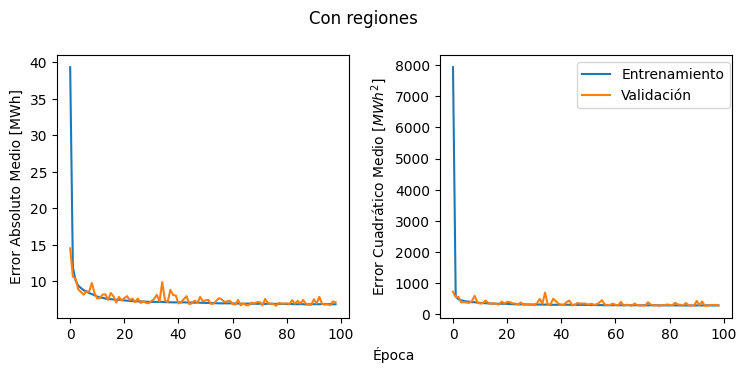

c:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................

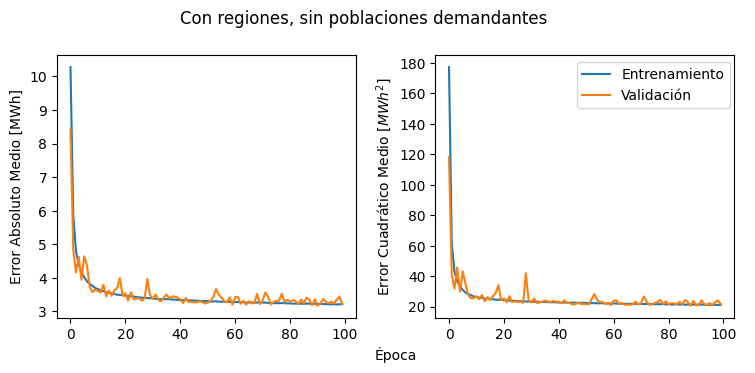

c:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



..............................................

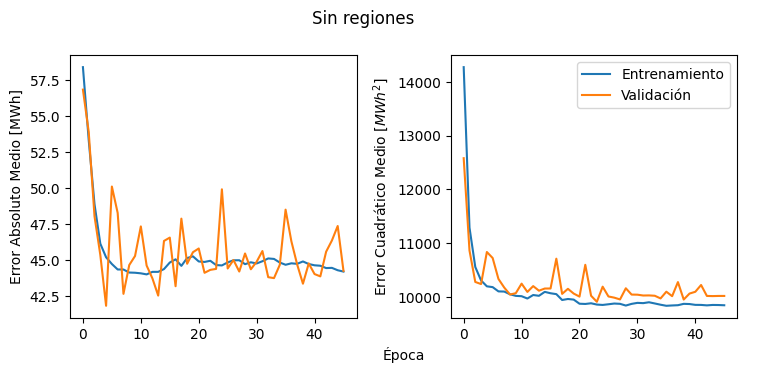

c:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................

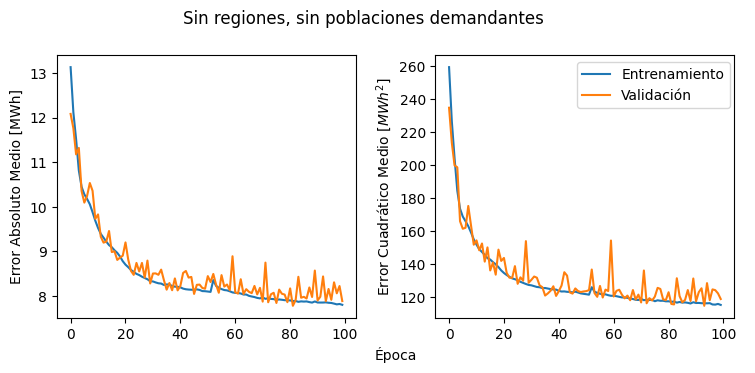

In [173]:
for i in range(0, len(datasets)):
    e_time, epoch = train_model(models[i], datasets[i])
    histories.append([m_names[i], e_time, epoch + 1])

histories_df = pd.DataFrame(histories, columns = ['Tipo de dataset', 'Tiempo utilizado', 'Epocas'])

In [174]:
histories_df

,Tipo de dataset,Tiempo utilizado,Epocas
0,Con regiones,588.059552,99
1,"Con regiones, sin poblaciones demandantes",540.112192,100
2,Sin regiones,267.290239,46
3,"Sin regiones, sin poblaciones demandantes",513.364717,100


In [175]:
results = []

  90/1008 [=>............................] - ETA: 1s

1008/1008 [==============================] - 1s 1ms/step
Con regiones


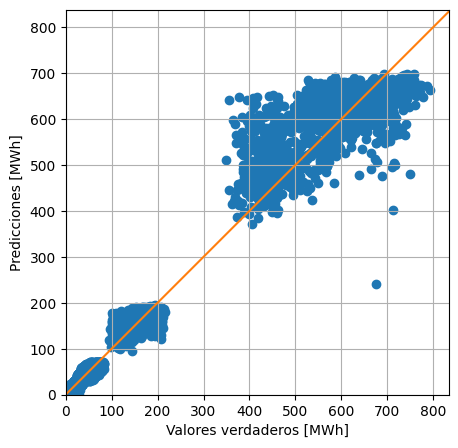

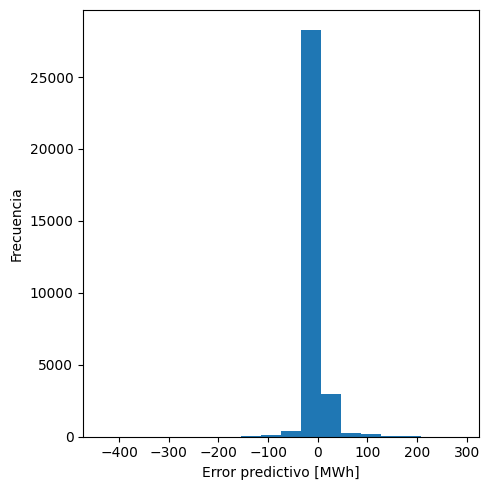

912/912 [==============================] - 1s 1ms/step
Con regiones, sin poblaciones demandantes


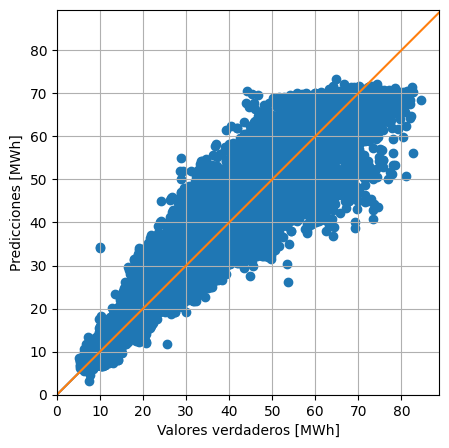

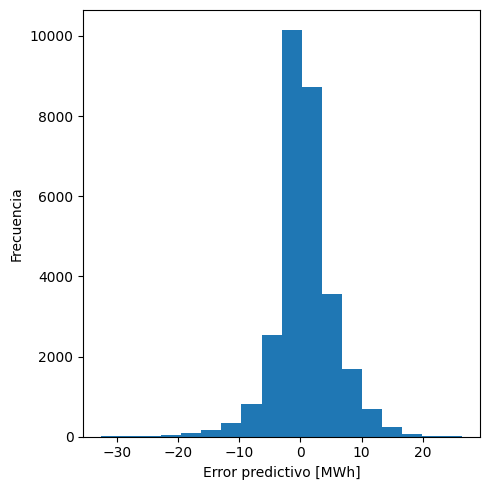

1008/1008 [==============================] - 1s 1ms/step
Sin regiones


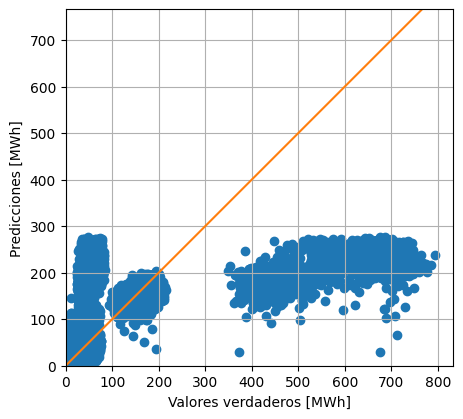

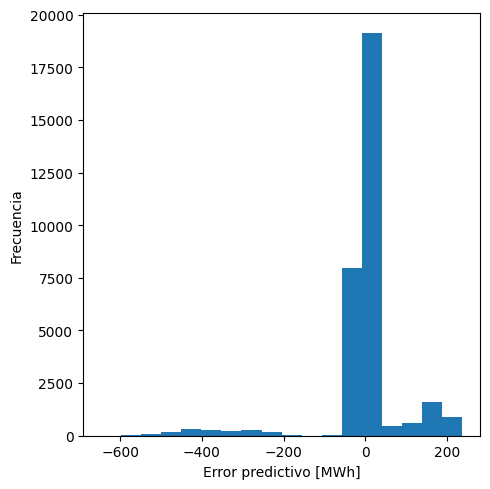

912/912 [==============================] - 1s 1ms/step
Sin regiones, sin poblaciones demandantes


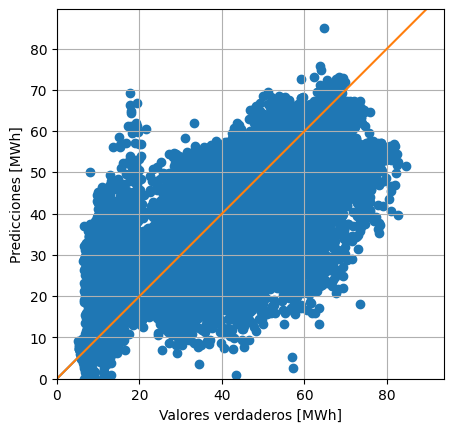

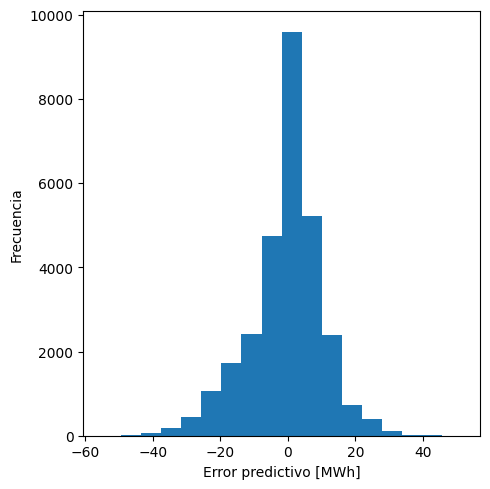

In [176]:
for i in range(0, len(datasets)):
    results.append(predict_model(models[i], datasets[i]))

In [177]:
results_df = pd.DataFrame(results, columns = ['Name', 'Pred', 'MAE', 'MSE', 'MAPE', 'MRE', 'R2 Score'])
results_df.drop(columns = 'Pred')

,Name,MAE,MSE,MAPE,MRE,R2 Score
0,Con regiones,7.049146,310.896574,0.126346,436.296175,0.978772
1,"Con regiones, sin poblaciones demandantes",3.338047,23.393905,0.113544,32.551007,0.915212
2,Sin regiones,43.434105,9607.081170,0.788577,646.722056,0.344041
3,"Sin regiones, sin poblaciones demandantes",7.838633,117.476371,0.315931,55.321470,0.574225


In [204]:
results_df

,Name,MAE,MSE,MAPE,MRE,R2 Score
0,Con regiones,13.092505,809.694837,0.299730,302.572137,0.944715
1,"Con regiones, sin poblaciones demandantes",8.494019,109.155485,0.412111,41.093277,0.604383
2,Sin regiones,50.902997,10631.189909,1.094202,658.271135,0.274117
3,"Sin regiones, sin poblaciones demandantes",11.894761,227.863677,0.509411,52.385775,0.174144


In [229]:
def plot_pred_error_area(datasets, results, up, low):
    pred_df = pd.DataFrame({'y_test': list(datasets[3]), 'y_pred': list(results[1])})
    pred_df['error'] = pred_df['y_test'] - pred_df['y_pred']
    pred_df['upper'] = pred_df['y_pred'] + abs(pred_df['error'])
    pred_df['lower'] = pred_df['y_pred'] - abs(pred_df['error'])

    # subset
    pred_temp = pred_df.iloc[up:low] 
    pred_temp['y_pred'].plot(figsize=(15, 4))
    plt.fill_between(pred_temp.index, pred_temp.upper, pred_temp.lower, where= pred_temp.upper > pred_temp.lower,
    facecolor='red', alpha=0.5, interpolate=True)
    plt.title('Predicción de validación para escenario {}'.format(results[0]))
    plt.show()

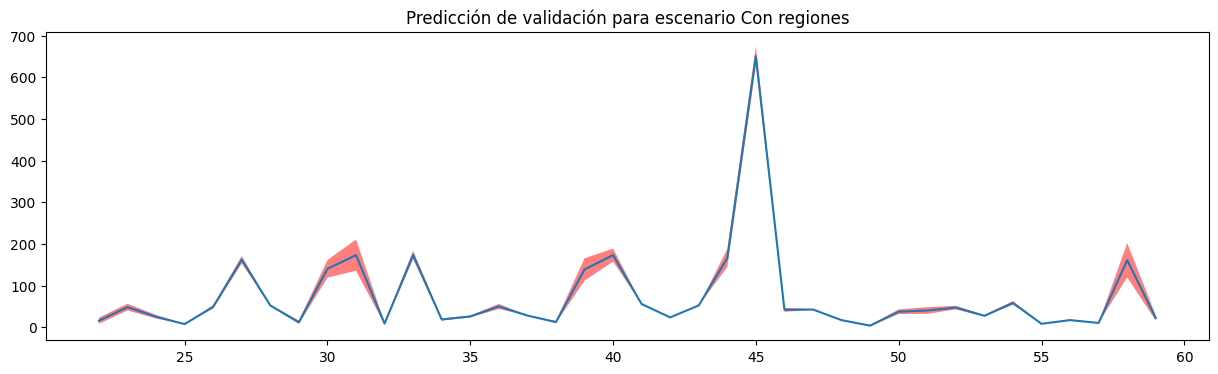

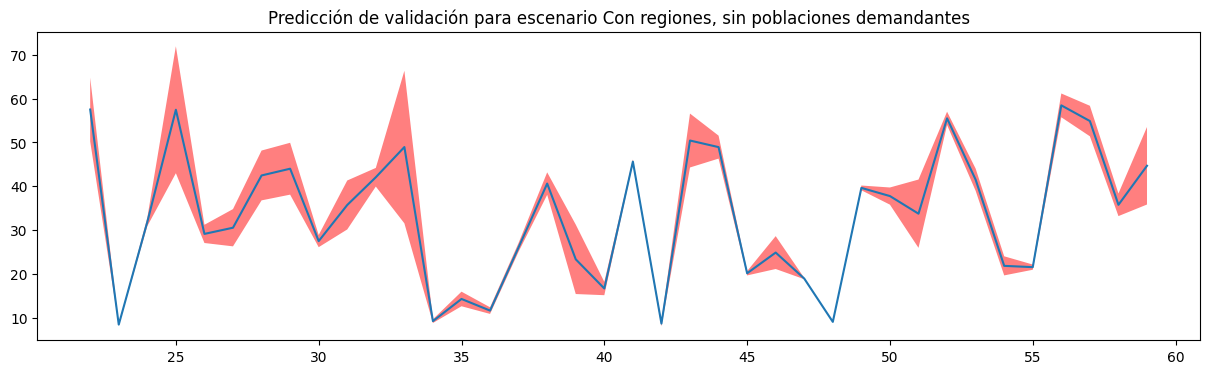

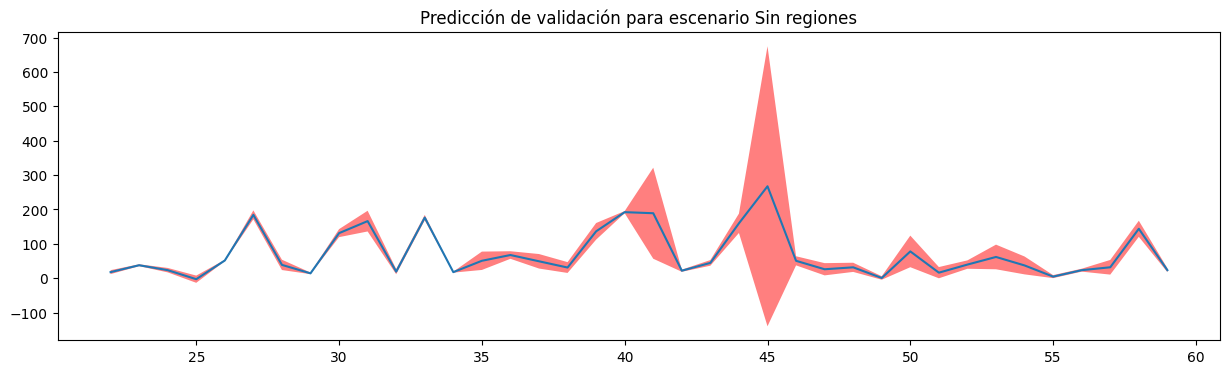

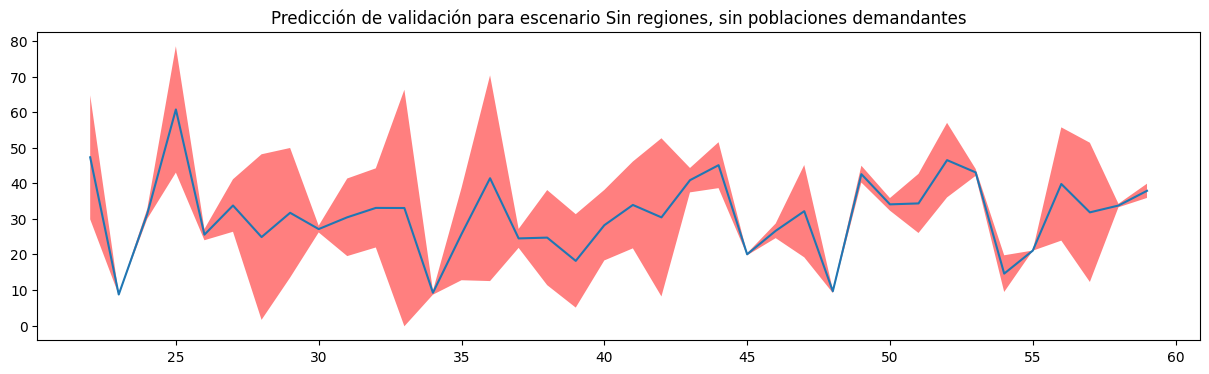

In [231]:
for i in range(0, len(datasets)):
    plot_pred_error_area(datasets[i], results_df.iloc[i], 22, 60)

## No tan importante

In [ ]:
y = dfFinal['ENERGY']
X = dfFinal.drop(columns=['ENERGY', 'INTERCXN'], errors = 'ignore')

In [ ]:
np.unique(y)

In [ ]:
# Transform regions to categories
X["REGION"] = X["REGION"].astype('category').cat.codes
X.head()

#### Distribución del modelo en datos de entrenamiento y datos de prueba
Se reparten las instancias del repositorio en los grupos de entrenamiento y prueba, considerando una proporción de entrenamiento/prueba de __80/20__ respectivamente. Ademas, se define que la semilla del estado de aleatoriedad `random_state` sea __1__ para que su ejecución sea reproducible.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)
print("Entrenamiento: ", X_train.shape[0], " instancias; Prueba: ", Y_test.shape[0], " instancias")

In [ ]:
# Scale input data
scaler = prep.StandardScaler()
scaleX_train = scaler.fit_transform(X_train)
scaleX_test = scaler.fit_transform(X_test)
print(scaleX_train)

In [ ]:
## Normalización de los datos
norm = prep.MinMaxScaler()
normX_train = norm.fit_transform(scaleX_train)
normX_test = norm.fit_transform(scaleX_test)
print(normX_train)

### Dataset con atributos regionales excepto demandas importantes (Guatemala y Escuintla)

In [ ]:
dfreg = dfFinal.loc[(dfFinal['REGION'] != 'GUATEMALA') & (dfFinal['REGION'] != 'ESCUINTLA')]
yrg = dfreg['ENERGY']
Xrg = dfreg.drop(columns=['ENERGY', 'INTERCXN'], errors = 'ignore')

In [ ]:
# Transform regions to categories
Xrg["REGION"] = Xrg["REGION"].astype('category').cat.codes
Xrg.head()

#### Distribución del modelo en datos de entrenamiento y datos de prueba
Se reparten las instancias del repositorio en los grupos de entrenamiento y prueba, considerando una proporción de entrenamiento/prueba de __80/20__ respectivamente. Ademas, se define que la semilla del estado de aleatoriedad `random_state` sea __1__ para que su ejecución sea reproducible.

In [ ]:
X_train_rg, X_test_rg, Y_train_rg, Y_test_rg = train_test_split(Xrg, yrg, test_size = 0.2, random_state = 1, shuffle = True)
print("Entrenamiento: ", X_train_rg.shape[0], " instancias; Prueba: ", Y_test_rg.shape[0], " instancias")

In [ ]:
# Scale input data
scaler = prep.StandardScaler()
scaleXrg_train = scaler.fit_transform(X_train_rg)
scaleXrg_test = scaler.fit_transform(X_test_rg)
print(scaleXrg_train)

In [ ]:
## Normalización de los datos
norm = prep.MinMaxScaler()
normXrg_train = norm.fit_transform(scaleXrg_train)
normXrg_test = norm.fit_transform(scaleXrg_test)
print(normX_train)

### Dataset sin atributos regionales

In [ ]:
ynrg = dfFinal['ENERGY']
Xnrg = dfFinal.drop(columns=['ENERGY', 'INTERCXN', 'REGION'], errors = 'ignore')

#### Distribución del modelo en datos de entrenamiento y datos de prueba
Se reparten las instancias del repositorio en los grupos de entrenamiento y prueba, considerando una proporción de entrenamiento/prueba de __80/20__ respectivamente. Ademas, se define que la semilla del estado de aleatoriedad `random_state` sea __1__ para que su ejecución sea reproducible.

In [ ]:
X_train_nrg, X_test_nrg, Y_train_nrg, Y_test_nrg = train_test_split(Xnrg, ynrg, test_size = 0.2, random_state = 1, shuffle = True)
print("Entrenamiento: ", X_train_nrg.shape[0], " instancias; Prueba: ", Y_test_nrg.shape[0], " instancias")

In [ ]:
# Scale input data
scaler = prep.StandardScaler()
scaleXnrg_train = scaler.fit_transform(X_train_nrg)
scaleXnrg_test = scaler.fit_transform(X_test_nrg)
print(scaleXnrg_train)

In [ ]:
## Normalización de los datos
norm = prep.MinMaxScaler()
normXnrg_train = norm.fit_transform(scaleXnrg_train)
normXnrg_test = norm.fit_transform(scaleXnrg_test)
print(normX_train)

### Dataset sin atributos regionales que excluye demandas importantes (Guatemala y Escuintla)

In [ ]:
dfreg = dfFinal.loc[(dfFinal['REGION'] != 'GUATEMALA') & (dfFinal['REGION'] != 'ESCUINTLA')]
ynr = dfreg['ENERGY']
Xnr = dfreg.drop(columns=['ENERGY', 'INTERCXN', 'REGION'], errors = 'ignore')

#### Distribución del modelo en datos de entrenamiento y datos de prueba
Se reparten las instancias del repositorio en los grupos de entrenamiento y prueba, considerando una proporción de entrenamiento/prueba de __80/20__ respectivamente. Ademas, se define que la semilla del estado de aleatoriedad `random_state` sea __1__ para que su ejecución sea reproducible.

In [ ]:
X_train_nr, X_test_nr, Y_train_nr, Y_test_nr = train_test_split(Xnr, ynr, test_size = 0.2, random_state = 1, shuffle = True)
print("Entrenamiento: ", X_train_nr.shape[0], " instancias; Prueba: ", Y_test_nr.shape[0], " instancias")

In [ ]:
# Scale input data
scaler = prep.StandardScaler()
scaleXnr_train = scaler.fit_transform(X_train_nr)
scaleXnr_test = scaler.fit_transform(X_test_nr)
print(scaleXnr_train)

In [ ]:
## Normalización de los datos
norm = prep.MinMaxScaler()
normXnr_train = norm.fit_transform(scaleXnr_train)
normXnr_test = norm.fit_transform(scaleXnr_test)
print(normXnr_train)

### Regresión con Redes Neuronales



In [ ]:
# Para normalizar los datos requerimos algunos datos estadisticos
train_stats = pd.DataFrame(X_train).describe()
train_stats = train_stats.transpose()
train_stats

### Dataset sin atributos regionales

In [ ]:
modeln = build_model(normXnrg_train)
modeln.summary()

#### Prueba del modelo

In [ ]:
example_batch = normXnrg_train[:10]
example_result = modeln.predict(example_batch)
example_result

#### Entrenamiento con interrupción para red neuronal con 100 épocas 

Se procede a entrenar el modelo DNN con 100 épocas. Las métricas de rendimiento seleccionadas para el modelo son el error absoluto medio ($MAE$) y error cuadrático medio ($MSE$).
<div class="alert alert-block alert-info">
<i class="fa fa-info-circle"></i>
<b>IMPORTANTE:</b> El modelo es susceptible a llegar a un punto en que no mejore su aprendizaje, o incluso deteriore su nivel de error de validación (sobre entrenamiento). Por tanto, se propone establecer una devolución de llamada <code>early_stop</code> o <b>EarlyStopping</b>, que detiene el entrenamiento si determina que nivel de error de validación no disminuya. Se establece un nivel de paciencia <code>patience</code> de 10 épocas, donde evalúa si el proceso se podría estancar en este rango.
</div>

In [ ]:
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor = "loss", patience = 10)

# Save performance indicator in history object
history = modeln.fit(normXnrg_train, Y_train_nrg, epochs = EPOCHS, validation_split = 0.2, verbose = 1, callbacks = [early_stop])

Se evalúa el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`. El modelo DNN parece no caer en un sobre entrenamiento, debido a que los niveles de MAE y MSE, tanto para el entrenamiento como para la validación, son estables en las épocas previas a la interrupción del proceso. 

In [ ]:
# Observar los reultados del entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_history(history)

#### Predicción a través de la red neuronal
Ambos modelos proyectarán los valores del atributo `ENERGY`.

In [ ]:
# Predicciones para los resultados en el conjunto de pruebas
y_pred_nrg = modeln.predict(normXnrg_test).flatten()

#### Resultados y comparación entre modelos
##### Evaluación de error absoluto medio (MAE) y error cuadrático medio (MSE)
Se evidencia que las mediciones de error son superiores para el algoritmo de redes neuronales densas, pero adquiere un mayor coeficiente de correlación de Pearson ($R^2$). La correlación de ambos modelos se considera estadísticamente significativa porque supera __0.7071 unidades__. 

In [ ]:
loss, mae, mse = modeln.evaluate(normXnrg_test, Y_test_nrg, verbose = 2)
print("Probando establecer Error Absoluto Medio: {:5.2f} GWh".format(mae))

In [ ]:
print("Metricas para Red Nueronal Densa (DNN)")
print('Mean Absolute Error (MAE):', mt.mean_absolute_error(Y_test_nrg, y_pred_nrg))
print('Mean Squared Error (MSE):', mt.mean_squared_error(Y_test_nrg, y_pred_nrg))
print('Mean Absolute Percentage Error (MAPE):', mt.mean_absolute_percentage_error(Y_test_nrg, y_pred_nrg))
print('Max Residual Error:', mt.max_error(Y_test_nrg, y_pred_nrg))
print('R^2:', mt.r2_score(Y_test_nrg, y_pred_nrg))

En la siguente gráficas se observa el ajuste del modelo, sus valores proyectados vs. verdaderos y la línea de regresión unitaria. Entre más se ajusten a ella, el modelo tendrá mejor desempeño.

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Ajuste del modelo según algoritmo de regresión")

ax.grid()
ax.scatter(Y_test_nrg, y_pred_nrg)
#ax.set_title("Red Neuronal Densa (DNN)")
ax.plot([0, 25], [0, 25])
ax.axis("square")
ax.set_xlim(0, 18)
ax.set_ylim(0, 18)

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Valores verdaderos")
plt.ylabel("Predicciones")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Error predictivo según modelo")

error_dnn = y_pred_nrg.flatten() - Y_test_nrg
ax.hist(error_dnn, bins = 18)
#ax.set_title("Red Neuronal Densa (DNN)")

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Error predictivo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### Dataset sin atributos regionales ni demandas importantes (Guatemala y Escuintla)

In [ ]:
modelnr = build_model(normXnr_train)
modelnr.summary()

In [ ]:
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor = "loss", patience = 10)

# Save performance indicator in history object
history = modelnr.fit(normXnr_train, Y_train_nr, epochs = EPOCHS, validation_split = 0.2, verbose = 1, callbacks = [early_stop])

Se evalúa el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`. El modelo DNN parece no caer en un sobre entrenamiento, debido a que los niveles de MAE y MSE, tanto para el entrenamiento como para la validación, son estables en las épocas previas a la interrupción del proceso. 

In [ ]:
# Observar los reultados del entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_history(history)

#### Predicción a través de la red neuronal
Ambos modelos proyectarán los valores del atributo `ENERGY`.

In [ ]:
# Predicciones para los resultados en el conjunto de pruebas
y_pred_nr = modelnr.predict(normXnr_test).flatten()

#### Resultados y comparación entre modelos
##### Evaluación de error absoluto medio (MAE) y error cuadrático medio (MSE)
Se evidencia que las mediciones de error son superiores para el algoritmo de redes neuronales densas, pero adquiere un mayor coeficiente de correlación de Pearson ($R^2$). La correlación de ambos modelos se considera estadísticamente significativa porque supera __0.7071 unidades__. 

In [ ]:
loss, mae, mse = modelnr.evaluate(normXnr_test, Y_test_nr, verbose = 2)
print("Probando establecer Error Absoluto Medio: {:5.2f} GWh".format(mae))

In [ ]:
print("Metricas para Red Nueronal Densa (DNN)")
print('Mean Absolute Error (MAE):', mt.mean_absolute_error(Y_test_nr, y_pred_nr))
print('Mean Squared Error (MSE):', mt.mean_squared_error(Y_test_nr, y_pred_nr))
print('Mean Absolute Percentage Error (MAPE):', mt.mean_absolute_percentage_error(Y_test_nr, y_pred_nr))
print('Max Residual Error:', mt.max_error(Y_test_nr, y_pred_nr))
print('R^2:', mt.r2_score(Y_test_nr, y_pred_nr))

En la siguente gráficas se observa el ajuste del modelo, sus valores proyectados vs. verdaderos y la línea de regresión unitaria. Entre más se ajusten a ella, el modelo tendrá mejor desempeño.

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Ajuste del modelo según algoritmo de regresión")

ax.grid()
ax.scatter(Y_test_nr, y_pred_nr)
#ax.set_title("Red Neuronal Densa (DNN)")
ax.plot([0, 25], [0, 25])
ax.axis("square")
ax.set_xlim(0, 18)
ax.set_ylim(0, 18)

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Valores verdaderos")
plt.ylabel("Predicciones")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Error predictivo según modelo")

error_dnn = y_pred_nr.flatten() - Y_test_nr
ax.hist(error_dnn, bins = 18)
#ax.set_title("Red Neuronal Densa (DNN)")

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Error predictivo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### Dataset con atributos regionales

In [ ]:
modelr = build_model(normXrg_train)
modelr.summary()

In [ ]:
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor = "loss", patience = 10)

# Save performance indicator in history object
history = modelr.fit(normXrg_train, Y_train_rg, epochs = EPOCHS, validation_split = 0.2, verbose = 1, callbacks = [early_stop])

In [ ]:
# Observar los reultados del entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_history(history)

#### Predicción a través de la red neuronal
Ambos modelos proyectarán los valores del atributo `ENERGY`.

In [ ]:
# Predicciones para los resultados en el conjunto de pruebas
y_pred_rg = modelr.predict(normXrg_test).flatten()

#### Resultados y comparación entre modelos
##### Evaluación de error absoluto medio (MAE) y error cuadrático medio (MSE)
Se evidencia que las mediciones de error son superiores para el algoritmo de redes neuronales densas, pero adquiere un mayor coeficiente de correlación de Pearson ($R^2$). La correlación de ambos modelos se considera estadísticamente significativa porque supera __0.7071 unidades__. 

In [ ]:
loss, mae, mse = modeln.evaluate(normXrg_test, Y_test_rg, verbose = 2)
print("Probando establecer Error Absoluto Medio: {:5.2f} GWh".format(mae))

In [ ]:
print("Metricas para Red Nueronal Densa (DNN)")
print('Mean Absolute Error (MAE):', mt.mean_absolute_error(Y_test_rg, y_pred_rg))
print('Mean Squared Error (MSE):', mt.mean_squared_error(Y_test_rg, y_pred_rg))
print('Mean Absolute Percentage Error (MAPE):', mt.mean_absolute_percentage_error(Y_test_rg, y_pred_rg))
print('Max Residual Error:', mt.max_error(Y_test_rg, y_pred_rg))
print('R^2:', mt.r2_score(Y_test_rg, y_pred_rg))

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Ajuste del modelo según algoritmo de regresión")

ax.grid()
ax.scatter(Y_test_rg, y_pred_rg)
#ax.set_title("Red Neuronal Densa (DNN)")
ax.plot([0, 25], [0, 25])
ax.axis("square")
ax.set_xlim(0, 18)
ax.set_ylim(0, 18)

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Valores verdaderos")
plt.ylabel("Predicciones")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Error predictivo según modelo")

error_dnn = y_pred_rg.flatten() - Y_test_rg
ax.hist(error_dnn, bins = 18)
#ax.set_title("Red Neuronal Densa (DNN)")

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Error predictivo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### Dataset con atributos regionales excepto poblaciones importantes (Guatemala y Escuintla)

In [ ]:
model = build_model(normX_train)
model.summary()

In [ ]:
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor = "loss", patience = 10)

# Save performance indicator in history object
history = model.fit(normX_train, Y_train, epochs = EPOCHS, validation_split = 0.2, verbose = 1, callbacks = [early_stop])

In [ ]:
# Observar los reultados del entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_history(history)

#### Predicción a través de la red neuronal
Ambos modelos proyectarán los valores del atributo `ENERGY`.

In [ ]:
# Predicciones para los resultados en el conjunto de pruebas
y_pred = model.predict(normX_test).flatten()

#### Resultados y comparación entre modelos
##### Evaluación de error absoluto medio (MAE) y error cuadrático medio (MSE)
Se evidencia que las mediciones de error son superiores para el algoritmo de redes neuronales densas, pero adquiere un mayor coeficiente de correlación de Pearson ($R^2$). La correlación de ambos modelos se considera estadísticamente significativa porque supera __0.7071 unidades__. 

In [ ]:
loss, mae, mse = modeln.evaluate(normX_test, Y_test, verbose = 2)
print("Probando establecer Error Absoluto Medio: {:5.2f} GWh".format(mae))

In [ ]:
print("Metricas para Red Nueronal Densa (DNN)")
print('Mean Absolute Error (MAE):', mt.mean_absolute_error(Y_test, y_pred))
print('Mean Squared Error (MSE):', mt.mean_squared_error(Y_test, y_pred))
print('Mean Absolute Percentage Error (MAPE):', mt.mean_absolute_percentage_error(Y_test, y_pred))
print('Max Residual Error:', mt.max_error(Y_test, y_pred))
print('R^2:', mt.r2_score(Y_test, y_pred))

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Ajuste del modelo según algoritmo de regresión")

ax.grid()
ax.scatter(Y_test, y_pred)
#ax.set_title("Red Neuronal Densa (DNN)")
ax.plot([0, 25], [0, 25])
ax.axis("square")
ax.set_xlim(0, 18)
ax.set_ylim(0, 18)

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Valores verdaderos")
plt.ylabel("Predicciones")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(6, 6))
#plt.suptitle("Error predictivo según modelo")

error_dnn = y_pred.flatten() - Y_test
ax.hist(error_dnn, bins = 18)
#ax.set_title("Red Neuronal Densa (DNN)")

fig.add_subplot(1, 1, 1, frame_on = False)
plt.tick_params(labelcolor = "none", bottom = False, left = False)
plt.xlabel("Error predictivo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## Clustering

### Tuneo del cluster con el método del codo
Se puede determinar el hiperparámetro óptimo del codo por medio del método del codo, después de realizar prueba y ensayo del nivel de distorsión en cada modelo con una determinada cantidad de iteraciones. Luego, se realiza una gráfica que muestra el cambio en la distorsión con respecta a la cantidad de clusters (o grupos) seleccionados. Se escoge el codo, o el punto en donde cambia la pendiente de la curva.
De acuerdo con el análisis gráfico, el codo se halla en la tercera iteración, lo que indica que el valor óptimo de k es __3__.


In [ ]:
# Iterar el modelo para obtener el arreglo de distorsiones
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init = 25, random_state = 123)
    kmeanModel.fit(X = normeX)
    distortions.append(kmeanModel.inertia_)

In [ ]:
# Graficar las distorsiones del modelo
plt.figure(figsize = (16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('El método del codo para mostrar el valor k óptimo')
plt.show()

In [ ]:
# Se realizar una clasificacion sobre los dos atributos de interés
data = dfFinal[['ENERGY','T2M']]
data

### Técnica de agrupamiento con 3 y 4 clusters

In [ ]:
# Grupos de relación entre el casos acumulados de covid y el porcentaje de sanidad
for class_value in range(3):
    row_ix = np.where(y.values == class_value) # obtenemos los índices de fila para las muestras dentro de esta clase
    plt.scatter(normeX[row_ix, 5], normeX[row_ix, 6])
plt.grid()
plt.show()

In [ ]:
kmeans = []
# Modelo con 3 clusters
kmeans.append(KMeans(n_clusters = 3, n_init = 25, random_state = 123))
kmeans[0].fit(X = normeX)

#Modelo con 4 clusters
kmeans.append(KMeans(n_clusters = 4, n_init = 25, random_state = 123))
kmeans[1].fit(X = normeX)

In [ ]:
# Clasificación con el modelo kmeans
y_predict = []
y_predict.append(kmeans[0].predict(normeX))
y_predict.append(kmeans[1].predict(normeX))

In [ ]:
def grafico_compara_k(scale, ypred, km, x, y):
  fig, axes = plt.subplots(nrows = 1, ncols = len(km), figsize = (16, 10))

  for i, ax in enumerate(axes.flat):
    for b in np.unique(ypred[i]):
      ax.scatter(
        x = scale[ypred[i] == b, x],
        y = scale[ypred[i] == b, y],
        marker = 'o',
        label = f'Cluster {b}')
    ax.scatter(
      x = km[i].cluster_centers_[:, x],
      y = km[i].cluster_centers_[:, y], 
      c = 'black',
      s = 200,
      marker = '*',
      label  = 'Centroide')
    ax.set_title(f'Clasificación con {i+3} clusters')
    ax.set_ylabel('Porcentaje del PIB para inversión en salud')
    ax.set_xlabel('Cantidad de decesos')
    ax.legend()

In [ ]:
grafico_compara_k(normeX, y_predict, kmeans, 0, 5)

In [ ]:
kx = kmeans[0].fit(X=X_scaled)
labels = kx.labels_
mt.silhouette_score(X, labels, metric='euclidean')

In [ ]:
mt.homogeneity_completeness_v_measure(y, labels)

In [ ]:
kx = kmeans[1].fit(X=X_scaled)
labels = kx.labels_
mt.silhouette_score(X, labels, metric='euclidean')

---
<a id="section3"></a>
## Referencias

European Commission. (2021). Datos del coronavirus COVID-19 — diariamente (hasta el 14 de diciembre de 2020). https://data.europa.eu/data/datasets/covid-19-coronavirus-data-daily-up-to-14-december-2020?locale=es 
<br>OMS. (2021, 1 abril). Atención primaria de salud. https://www.who.int/es/news-room/fact-sheets/detail/primary-health-care 
<br>OPS. (2021, 10 noviembre). Se necesita inversión urgente en la atención primaria de salud para garantizar la recuperación tras la COVID-19 en la Región de las Américas. Organización Panamericana de la Salud. https://www.paho.org/es/noticias/10-11-2021-se-necesita-inversion-urgente-atencion-primaria-salud-para-garantizar
<br>WHO. (2022). Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%) Data by country. Global Health Observatory data repository. https://apps.who.int/gho/data/view.main.GHEDCHEGDPSHA2011v